![Map of Digital Design in Architecture](images/map-digital-design-in-architecture.png)

This is a map of **Digital Design in Architecture**. It is created with data from 12,000 articles published between 1975 and 2019.

You can download a [high-res PDF version here](images/map-digital-design-in-architecture.pdf).

You can use this map to learn about the various concepts that build the field of digital design in architecture and the main authors defining them.

You can also check what is not there yet.

The code i used to generate it is below.

# IDEA

I recently found this interesting [visualization of 20th Century Philosophy by Maximilian Noichl](https://homepage.univie.ac.at/noichlm94/posts/structure-of-recent-philosophy-iii/).
The chart is drawn by sampling and clustering some 50,000 peer-reviewed journal article on philosophy. 
It was amazing how I was able to discover relationships and authors in a discipline, which I am not familiar with, through the data clustering that it presented!

So I wanted to do a similar thing for my field of research for two reasons:
- I feel at home working in a data-driven workflow. So it felt natural to try and help myself structure the sourcing process for the literature review for my PhD thesis using a data-driven approach as well. 
- I was curious what discussion such a visualization would prompt in our computational design community. 

Maximilian has generously shared his code and when I emailed him, he advised me on what to pay attention to when creating my own map. Big thanks to Max!
I used Max's code as a base to built this map. My changes were in the cluster tree chart and in the text analysis. I also documented the process on how to get the data needed for such a map.

The idea of this Jupyter notebook is that you can use it to produce your own map for your own field of interest. It is build step by step but is meant to be used in a loop where you would see the result in one step and go back few steps to change the parameters (for example the size of the research clusters - Max used 440, in my case this number was too big because I had less articles) and run again.

# INIT
Let's initialize the environment and load the needed libraries. 
Check the [SETUP.md](SETUP.md) file for instructions on how to set up your development environment so that you can run this Jupyter notebook.

In [1]:
# This cell loads the needed Python libraries
import metaknowledge as mk
import pandas as pd
import numpy as np
from random import randint
import datetime
import scipy as scipy

import csv
import textwrap

%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt

#For Tables:
from IPython.display import display
from IPython.display import Latex
pd.set_option('display.max_columns', 500)

#For R (ggplot2)

#check the rpy situation by uncommenting the following
#%run -m rpy2.situation

#use the following on macOS, comment it out on Windows
%load_ext rpy2.ipython
#on Windows rpy2 doesnt show output of R cells, use the one below if on Windows
#use the following on Windows, comment it out on macOS
#%load_ext RWinOut 

# DATA

The method to generate this map of the research landscape uses publication data from journals and conferences. The clustering is based on the co-citation patterns, i.e. which authors cite each others' papers most often.

## Where does the data come from?

So as data we need data from publications. The method by Max Noichl used [Web-Of-Science (WOS)](https://www.webofknowledge.com/) as the data source. I cannot publish the data I used to generate the map since I don't have permission to distribute it but I can show you how to get the data on your own.

## How to download publication metadata from Web-of-Science (WOS)

Open the WOS website and use your institutional sign in to log in. For German universities like the one I am at use the `German Higher Education and Research (DFN-AAI)` option and find your university on the next page.

Now let's do a sample search. Enter `International Journal of Architectural Computing` in the search field and change the type to `Publication Name`.

![WOS search](images/method/wos_search.png)
<img src="images/method/wos_search.png" alt="WOS search" width="75%"/>

The search results are 149 as of 5th August 2020.

<img src="images/method/wos_results.png" alt="WOS results" width="75%"/>

Click on the `Export...` button and choose `Other File Formats`.

<img src="images/method/wos_export_formats.png" alt="WOS Export formats" width="232"/>

In the next window choose Records from 1 to 149. As content choose `Author, Title, Source, Abstract`. And as File Format choose Plain Text.

<img src="images/method/wos_export_options.png" alt="WOS Export options" width="290"/>

Click Export to download the file with the data.


## How I selected the data about publications on digital technology and architectural design

The data used in the next steps has been collected in January 2019. As more publications are being added to WOS over the years, the map will for sure change a bit.

### Step 1 — A list of established conferences
I made a list of the conferences and journals that where most often discussed at my department ([DDU at TU Darmstadt](https://www.dg.architektur.tu-darmstadt.de/fachgebiet_ddu/index.de.jsp)) and where my colleagues and I have had submitted papers to:

Conferences:
- AAG
- Acadia 
- CAAD futures
- Caadria
- Design Modelling Symposium
- eCAADe
- Fabricate
- RobArch
- Sigradi
- SimAUD

Peer-reviewed journals:
- IJAC

I checked how many papers from those are available on WOS. Not many :(

As you see below, I had only 1,600 something publications, yet I needed much more to create the map.
Anyway, I downloaded the metadata from WOS.

In [2]:
#list the established conferences
df = pd.read_csv('data/01a_established_conf.csv', delimiter=';')
display(df)

,SOURCE TITLE,ARTICLES ON WOS,INCLUDE IN MAP
0,ACADIA PROCEEDINGS,209,yes
1,ADVANCES IN ARCHITECTURAL GEOMETRY,22,yes
2,CAAD FUTURES PROCEEDINGS,33,yes
3,CAADRIA PROCEEDINGS,492,yes
4,DESIGN MODELLING SYMPOSIUM PROCEEDINGS,0,no
5,ECAADE PROCEEDINGS,787,yes
6,FABRICATE PROCEEDINGS,0,no
7,INTERNATIONAL JOURNAL OF ARCHITECTURAL COMPUTING,100,yes
8,ROBARCH PROCEEDINGS,0,no
9,SIGRADI PROCEEDINGS,0,no


### Step 2 — List of authors established in the field
So then I decided to start with a list of people and then derive the publication sources from it.
I made a list of the authors that are established in the field of digital design in architecture. Then I checked how many articles are listed in WOS for each author and downloaded their metadata.

In [3]:
#list the selected authors
df = pd.read_csv('data/02a_established_authors.csv', delimiter=';')
display(df)

,LAST NAME,FIRST NAME,ARTICLES ON WOS
0,Ahlquist,Sean,13
1,Aish,Robert,14
2,Alexander,Christopher,7
3,Bechthold,Martin,9
4,Brell-Cokcan,Sigrid,13
5,Burry,Mark,34
6,Burry,Jane,32
7,Carpo,Mario,34
8,Cross,Nigel,27
9,Eisenman,Peter,74


If you miss your hero in this list, email me or open an issue in this GitHub repo. However, the purpose of this list is to use it to get to a list of journals, so adding or removing one name might not change the results from the steps that follow.

Then I downloaded the publication data for those authors that was available on WOS.


Next we are interested in the journals where the authors from the list have published.

In [4]:
# take a glimpse at the data we have for top authors in the field
RCAuthor = mk.RecordCollection("data/02b_established_authors")
print(RCAuthor.glimpse())

RecordCollection glimpse made at: 2020-08-07 19:50:45
864 Records from files-from-/Users/antonsavov/_

Top Authors
1 Menges, Achim
2 EISENMAN, P
3 Vidler, Anthony
4 Carpo, Mario
5 Burry, Jane
6 PICON, A
6 VIDLER, A
7 STINY, G
7 Picon, Antoine

Top Journals
1 ARCHITECTURAL DESIGN
2 A + U-ARCHITECTURE AND URBANISM
3 ARCHITECTURE D AUJOURD HUI
4 ENVIRONMENT AND PLANNING B-PLANNING & DESIGN
5 DESIGN STUDIES
6 ARCHITECTURAL REVIEW
7 DIGITAL TURN IN ARCHITECTURE 1992-2012
8 LOTUS INTERNATIONAL
9 ARCHITECTURAL RECORD

Top Cited
1 STINY G, 1980, ENVIRON PLANN B, V7, P343, DOI 10.1068/b070343
2 Menges A, 2012, ARCHIT DESIGN, V82, P52, DOI 10.1002/ad.1379
3 STINY G, 1978, ENVIRON PLANN B, V5, P5, DOI 10.1068/b050005
4 Kolarevic Branko., 2003, ARCHITECTURE DIGITAL
4 Frazer J., 1995, EVOLUTIONARY ARCHITE
4 Gramazio Fabio, 2008, DIGITAL MAT ARCHITEC
5 Stiny G, 1975, PICTORIAL FORMAL ASP
6 Kolarevic B, 2005, PERFORMATIVE ARCHITE
6 STINY G, 1982, ENVIRON PLANN B, V9, P113


### Step 3 — Get a list of journals where established authors have published

I could use the publication data for the top authors to derive a list of journals. I got a list of 210 journals, conference proceedings and books. There were some interesting new sources in the list but also several problems with it. Some sources were not peer-reviewed, others didn't contain publications with citations, yet citing patterns are important for this map, some sources didn't have their focus on architecture and digital technology and so on. So the list needed cleaning up.

In [5]:
# list all journal ranked by occurence
topJU = RCAuthor.rankedSeries(tag='journal', pandasMode=False)
display(pd.DataFrame(topJU,columns=['Journal', 'Articles by top authors']))

# And export the list to a CSV file for manual review
with open("data/03_journals_from_established_authors.csv", "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    writer.writerows(topJU)

,Journal,Articles by top authors
0,ARCHITECTURAL DESIGN,191
1,A + U-ARCHITECTURE AND URBANISM,52
2,ARCHITECTURE D AUJOURD HUI,36
3,ENVIRONMENT AND PLANNING B-PLANNING & DESIGN,31
4,DESIGN STUDIES,25
5,ARCHITECTURAL REVIEW,23
6,DIGITAL TURN IN ARCHITECTURE 1992-2012,22
7,LOTUS INTERNATIONAL,21
8,ARCHITECTURAL RECORD,18
9,NOAH'S ARK: ESSAYS ON ARCHITECTURE,16


### Step 4 — Clean up the journal list
I exported the list of journals where the top authors had published in. Then I checked each journal one by one and excluded the really broad ones such as Architectural Digest, as well those focusing solely on engineering, history, art or aesthethical/political critique. I also removed any books from the list, such as DIGITAL TURN IN ARCHITECTURE by Mario Carpo.

Then I merged the list with the established conferences from step 1
I was left with 17 Journals.
Let's see how many articles this gives us.

In [6]:
#the updated list of journals
df = pd.read_csv('data/04a_cleaned_up_journals.csv', delimiter=';')
display(df)

,JOURNAL TITLE,ARTICLES BY TOP AUTHORS,ARTICLES ON WOS,INCLUDE,REASON
0,3D-ARCH 2015 - 3D VIRTUAL RECONSTRUCTION AND V...,1,63,yes,NaN
1,ACADIA PROCEEDINGS,25,209,yes,NaN
2,ADVANCES IN ARCHITECTURAL GEOMETRY 2016,5,22,yes,NaN
3,AI EDAM-ARTIFICIAL INTELLIGENCE FOR ENGINEERIN...,3,811,yes,NaN
4,ARCHITECTURAL DESIGN,191,6585,yes,NaN
5,AUTOMATION IN CONSTRUCTION,15,2325,yes,NaN
6,CAAD FUTURES PROCEEDINGS,1,33,yes,NaN
7,CAADRIA PROCEEDINGS,19,492,yes,NaN
8,COMPUTER-AIDED DESIGN,12,3811,yes,NaN
9,DESIGN STUDIES,25,506,yes,NaN


In [7]:
# take a glimpse at the data we have for now
RCtmp = mk.RecordCollection("data/04b_cleaned_up_journals")
print(RCtmp.glimpse())

RecordCollection glimpse made at: 2020-08-07 19:50:51
19031 Records from files-from-/Users/antonsavov/_

Top Authors
1 [Anonymous]
2 TOY, M
3 JENCKS, C
4 Toy, M
5 Castle, H
6 Castle, Helen
7 COOKE, C
8 Menges, Achim
9 Batty, Michael

Top Journals
1 ARCHITECTURAL DESIGN
2 COMPUTER-AIDED DESIGN
3 ENVIRONMENT AND PLANNING B-PLANNING & DESIGN
4 AUTOMATION IN CONSTRUCTION
5 AI EDAM-ARTIFICIAL INTELLIGENCE FOR ENGINEERING DESIGN ANALYSIS AND MANUFACTUR
6 DESIGN STUDIES
7 NEXUS NETWORK JOURNAL
8 PROCEEDINGS OF THE 19TH INTERNATIONAL CONFERENCE ON COMPUTER-AIDED ARCHITECTUR
9 PROCEEDINGS OF THE 20TH INTERNATIONAL CONFERENCE ON COMPUTER-AIDED ARCHITECTUR

Top Cited
1 STINY G, 1980, ENVIRON PLANN B, V7, P409, DOI 10.1068/b070409
2 Schon D, 1983, REFLECTIVE PRACTITIO
3 STINY G, 1978, ENVIRON PLANN B, V5, P5, DOI 10.1068/b050005
4 Hillier B, 1984, SOCIAL LOGIC SPACE
5 Piegl L., 1997, NURBS BOOK
6 GERO JS, 1990, AI MAG, V11, P26
7 Goldberg D. E, 1989, GENETIC ALGORITHMS S
8 Eastman C, 2011, BIM HDB

A little over 19000 articles. Not bad. I wanted to check for more.

### Step 5 — Fish for more data using Scimago

So using the website [Scimago](https://www.scimagojr.com/journalrank.php?category=2216) and filtering to the field of architecture, I looked for sources that:
1. Had a high ranking
2. Focused on digital technology and architecture
3. Had data available on WOS

This resulted only in one new journal being added to the list:

TECHNE-JOURNAL OF TECHNOLOGY FOR ARCHITECTURE AND ENVIRONMENT

However the whole exersize was quite interesting to get an overview of the publication landscape in architecture. If one day I decide to make a map of the whole architecture research, not just the one relating to digital design, the insights would be useful.

So let's load the data for the map.


### Step 6 — load and clean up data

First let's load the data and take a glimpse of what we have so far.

In [8]:
date_string = datetime.datetime.now().strftime("%Y-%m-%d-%H:%M")

#read the data for all journals
RC = mk.RecordCollection("data/06_all_journals")
print(RC.glimpse())

RecordCollection glimpse made at: 2020-08-07 19:50:57
19317 Records from files-from-/Users/antonsavov/_

Top Authors
1 [Anonymous]
2 TOY, M
3 JENCKS, C
4 Toy, M
5 Castle, H
6 Castle, Helen
7 COOKE, C
8 Menges, Achim
9 Batty, Michael

Top Journals
1 ARCHITECTURAL DESIGN
2 COMPUTER-AIDED DESIGN
3 ENVIRONMENT AND PLANNING B-PLANNING & DESIGN
4 AUTOMATION IN CONSTRUCTION
5 AI EDAM-ARTIFICIAL INTELLIGENCE FOR ENGINEERING DESIGN ANALYSIS AND MANUFACTUR
6 DESIGN STUDIES
7 NEXUS NETWORK JOURNAL
8 TECHNE-JOURNAL OF TECHNOLOGY FOR ARCHITECTURE AND ENVIRONMENT
9 PROCEEDINGS OF THE 19TH INTERNATIONAL CONFERENCE ON COMPUTER-AIDED ARCHITECTUR

Top Cited
1 STINY G, 1980, ENVIRON PLANN B, V7, P409, DOI 10.1068/b070409
2 Schon D, 1983, REFLECTIVE PRACTITIO
3 STINY G, 1978, ENVIRON PLANN B, V5, P5, DOI 10.1068/b050005
4 Hillier B, 1984, SOCIAL LOGIC SPACE
5 Piegl L., 1997, NURBS BOOK
6 GERO JS, 1990, AI MAG, V11, P26
7 Goldberg D. E, 1989, GENETIC ALGORITHMS S
8 Eastman C, 2011, BIM HDB GUIDE BUILDI
9 R

An intersting thing we can do with the data at this point is to see which are the TOP30 journals where the articles cited in the articles in the collection are published. This can help find more journals to include in the dataset.

In [9]:
# list TOP30 journals from the cited works in these articles

topJUcited = []
for R in RC:
    #topJUcited.append(list(set(R.getCitations().get('citeString'))))
    topJUcited.append(list(set(R.getCitations().get("journal"))))
#print(topJUcited[:10])
rankedJU = {}
for jlist in topJUcited:
    for ju in jlist:
        rankedJU[ju] = rankedJU.get(ju, 0) + 1
        
sorted_by_value = sorted(rankedJU.items(), key=lambda kv: kv[1], reverse=True)            
#RC.rankedSeries(tag='journal', pandasMode=False)
display(pd.DataFrame(sorted_by_value[:30], columns=['Journal','Times cited']))

,Journal,Times cited
0,COMPUT AIDED DESIGN,2681
1,AUTOMAT CONSTR,1922
2,ENVIRON PLANN B,1604
3,ACM T GRAPHIC,981
4,J CONSTR ENG M ASCE,848
5,J COMPUT CIVIL ENG,829
6,IEEE COMPUT GRAPH,779
7,DESIGN STUDIES,778
8,COMPUT AIDED GEOM D,774
9,LECT NOTES COMPUT SC,713


Next we will remove the articles which have less then a certain number of citations to reduce the noise in the map. We can also remove all articles that don't list the year of their publication, or are without abstracts. This helps later when we want to understand what each cluster is researching about. Let's print a glimpse of the data so far.

In [10]:
#prune the collection from articles that miss key data
RC2 = mk.RecordCollection()

for R in RC:
    randnr = randint(0, 4)
    
    if len(R.getCitations().get("author"))>=3: # and randnr==0 apply condition in order to downsample records
        #Here we kick out every paper that cites less then 3 authors. Why? because they
        #are so dissimilar from the others, that they only produce noise.  
   
        try:
            R['year']
            #if R['year']>1961:
            #R['abstract']  #Add this when working with abstracts. It removes every paper that has none. 
            #This can sometimes remove whole journals, that are archived without abstracts, so handle with care.
            RC2.add(R)
        except KeyError:
            pass
    else:
        pass
    

print(RC2.glimpse())


RC = RC2

RecordCollection glimpse made at: 2020-08-07 19:50:59
12572 Records from Empty

Top Authors
1 [Anonymous]
2 Menges, Achim
3 Li, Heng
4 Batty, Michael
5 BATTY, M
6 Wang, Xiangyu
7 JENCKS, C
8 Batty, M
8 Gero, John S.

Top Journals
1 COMPUTER-AIDED DESIGN
2 AUTOMATION IN CONSTRUCTION
3 ENVIRONMENT AND PLANNING B-PLANNING & DESIGN
4 ARCHITECTURAL DESIGN
5 AI EDAM-ARTIFICIAL INTELLIGENCE FOR ENGINEERING DESIGN ANALYSIS AND MANUFACTUR
6 DESIGN STUDIES
7 NEXUS NETWORK JOURNAL
8 TECHNE-JOURNAL OF TECHNOLOGY FOR ARCHITECTURE AND ENVIRONMENT
9 PROCEEDINGS OF THE 18TH INTERNATIONAL CONFERENCE ON COMPUTER-AIDED ARCHITECTUR

Top Cited
1 STINY G, 1980, ENVIRON PLANN B, V7, P409, DOI 10.1068/b070409
2 Schon D, 1983, REFLECTIVE PRACTITIO
3 STINY G, 1978, ENVIRON PLANN B, V5, P5, DOI 10.1068/b050005
4 Hillier B, 1984, SOCIAL LOGIC SPACE
5 Piegl L., 1997, NURBS BOOK
6 GERO JS, 1990, AI MAG, V11, P26
7 Goldberg D. E, 1989, GENETIC ALGORITHMS S
8 Eastman C, 2011, BIM HDB GUIDE BUILDI
9 RITTEL HWJ, 1973, 

Ok, we lost 7,000 articles. The clean up reduced the amount of datapoints to about 12,000 which is still ok. 

The glimpse shows us the most prolific researchers where we have the computational design superstar Achim Menges. We see the journals with the most publications in the dataset. And we see the top cited articles where the winner is [George Stiny's "Kindergarten Grammars: Designing with Froebel's Building Gifts"](https://journals.sagepub.com/doi/abs/10.1068/b070409).The [The Palladian Grammar](https://journals.sagepub.com/doi/abs/10.1068/b050005) again by Stiny is 3rd. [Bill Hillier's Space Syntax Book](https://www.cambridge.org/core/books/social-logic-of-space/6B0A078C79A74F0CC615ACD8B250A985) and [Horst Rittel's Dillemas in a General Theory of Planning](https://link.springer.com/article/10.1007/BF01405730) also make it in the TOP 10. So far so good.

Next let's assemble a clean list of all included journals and conferences so we can print it next to the map.

In [228]:
#list all journals where the papers in the data were published
# list all journal ranked by occurence
topJU = RC.rankedSeries(tag='journal', pandasMode=False)
#conference proceedings or journals sometimes appear as separate journals for each year or issue. lets combine them
combineConfProc = [
    # list of what to search for and what to change the name to and tally it up as
    [['acadia'], 'ACADIA CONFERENCE PROCEEDINGS'],
    [['ecaade','fusion:'], 'ECAADE CONFERENCE PROCEEDINGS'],
    [['caadria'], 'CAADRIA CONFERENCE PROCEEDINGS'],
    [['simaud'], 'SIMAUD CONFERENCE PROCEEDINGS'],
    [['caad futures'], 'CAAD FUTURES CONFERENCE PROCEEDINGS'],
]
journalList = []
confprocdict = {}
for j in topJU:
    #if conf name found, combine in conferences
    isConf = False
    jouName = j[0]
    for conf in combineConfProc:
        for searchphrase in conf[0]:
            if searchphrase.lower() in jouName.lower():
                isConf = True
                if not conf[1] in confprocdict:
                    confprocdict[conf[1]] = [conf[1],j[1]]
                else:
                    confprocdict[conf[1]][1] = confprocdict[conf[1]][1] + j[1]
    #wrapepdJuName = textwrap.fill(j[0],70)
    if not isConf:
        aju = [ jouName, j[1]]
        journalList.append(aju)
    #print(wrapepdJuName + " (" + str(j[1])+ ")")
    #print()
for conf in confprocdict:
    journalList.append(confprocdict[conf])

wrapper=textwrap.TextWrapper()
wrapper.width=60
wrapper.initial_indent=""
wrapper.subsequent_indent="    "
    
#sortedJournalList
journalList = sorted(journalList, key=lambda x: x[0][0])
journalListLabels = []
for journal in journalList:
    label = wrapper.fill(journal[0] + " (" + str(journal[1]) + ")")#+"\n"
    journalListLabels.append(label)
    #print(label )
journalListLabel = "THE MAP IS GENERATED FROM DATA FROM THE FOLLOWING PUBLICATIONS:" + "\n"+"\n".join([w for w in journalListLabels]) + "\nDATA SNAPSHOT 23 JAN 2019"
print(journalListLabel)

THE MAP IS GENERATED FROM DATA FROM THE FOLLOWING PUBLICATIONS:
3D-ARCH 2015 - 3D VIRTUAL RECONSTRUCTION AND VISUALIZATION
    OF COMPLEX ARCHITECTURES (63)
AUTOMATION IN CONSTRUCTION (2273)
ARCHITECTURAL DESIGN (1683)
AI EDAM-ARTIFICIAL INTELLIGENCE FOR ENGINEERING DESIGN
    ANALYSIS AND MANUFACTURING (734)
ADVANCES IN ARCHITECTURAL GEOMETRY 2016 (22)
ACADIA CONFERENCE PROCEEDINGS (118)
COMPUTER-AIDED DESIGN (3168)
COMPUTATIONAL ECOLOGIES: DESIGN IN THE ANTHROPOCENE (44)
CAADRIA CONFERENCE PROCEEDINGS (447)
CAAD FUTURES CONFERENCE PROCEEDINGS (33)
DESIGN STUDIES (486)
ENVIRONMENT AND PLANNING B-PLANNING & DESIGN (2030)
ECAADE CONFERENCE PROCEEDINGS (731)
INTERNATIONAL JOURNAL OF ARCHITECTURAL COMPUTING (85)
MASS CUSTOMISATION AND PERSONALISATION IN ARCHITECTURE AND
    CONSTRUCTION (17)
NEXUS NETWORK JOURNAL (369)
PERFORMANCE-ORIENTED ARCHITECTURE: RETHINKING ARCHITECTURAL
    DESIGN AND THE BUILT ENVIRONMENT (7)
SIMAUD CONFERENCE PROCEEDINGS (29)
TECHNE-JOURNAL OF TECHNOLOGY FOR ARC

# MAP

Now let’s do the map. The method is explained below with the code. The code for the first 4 steps (extracting the fetures, dimensionality reduction, 2D embedding with umap and clustering) is largely based on the [code shared by Max Noichl here](https://homepage.univie.ac.at/maximilian.noichl/posts/structure-of-recent-philosophy-ii/), so refer to his Jupyter Notebook for details.

## Build a multi-dimensional space of relationships

In order to arrange the publications in a 2D map (which is done with UMAP), and subsequently to determine the clusters, the publications datapoints need to be assigned `features`. The datapoints with more similar features will be placed closer to each other. Max Noichl carried out some experiments with features such as author, words in abstracts, title and so on and he recommends using the following two features:
- the cited works
- the cited authors

To extract the features we use `scikit-learn` and clean up the weakly linked points.

First let's do the cited works, then the cited authors and then fitler out weak links.

In [12]:
########### Cited Works - Features ############

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import re
drc = pd.DataFrame.from_dict(RC.forNLP(extraColumns=['journal','AU','FU','PD']))

d = []
citedAU = []
citestring =[]
for R in RC:

    d.append(list(set(R.getCitations().get("citeString")))) #To cluster by cited author
    citedAU.append(list(set(R.getCitations().get("author"))))
    citestring.append(list(set(R.getCitations().get("citeString"))))

drc["citedAU"] = citedAU
drc["citestring"] = citestring
#print(d[0])
authorslist = ['§'.join(filter(None,x)) for x in list(d)] 
#print(authorslist[0])

# vec = TfidfVectorizer(token_pattern=r'(?<=[^|§])[\s\w,\.:;]+(?=[$|§])')
vec = CountVectorizer(token_pattern=r'(?<=[§])[\s\w,\.:;\/\[\]-]+(?=[§])',binary=True, min_df = 3)#, min_df = 1)


Xrc = vec.fit_transform(authorslist)

In [13]:
########### Authors - Features ############

d = []
for R in RC:
    authors = list(set(R.getCitations().get("author")))
#    print(authors)
    authors = filter(None, authors)
    f = []
    for a in authors:
        f.append(' '.join([w for w in a.split(' ')if len(w)>2]))
        
    authors = f#' '.join(f)
    d.append(authors)
authorslist = [';'.join(filter(None,x)) for x in list(d)] 
vec = CountVectorizer(token_pattern=r'(?<=[;])[\s\w]+(?=[;])',binary=True, min_df = 10)

XrcAu = vec.fit_transform(authorslist)

In [14]:
k = [XrcAu,Xrc]
XrcFull = scipy.sparse.hstack(k).tocsr()

In [15]:
###### Filtering #######
from scipy.sparse import coo_matrix, vstack
from scipy.sparse import csr_matrix
import scipy as scipy
row_names = np.array(drc["id"])

newdf=[]
a = 0
# index by name:
for x in range(0,XrcFull.shape[0]): #Xrc.shape[0]):
    row_idx, = np.where(row_names == drc["id"][x])
    if np.diff(XrcFull[row_idx].tocsr().indptr) >= 4:
        if a == 0:
            k = [XrcFull[row_idx]]
        if a != 0:
            k.append(XrcFull[row_idx])
        a = a+1
        newdf.append(drc.loc[x])
        
drc = pd.DataFrame(newdf).reset_index()
M = scipy.sparse.vstack((k))

## Preliminary dimensionality reduction with SVD

Here is what Max Noichl says about this next step:
> "This is strictly speaking not necessary: We could pass our vectors directly to the umap-algorithm. But when we use a lot of data, we can get a sharper image when we clear out some noise with SVD beforehand. If we were interested more in classification and less in visualization, I would suggest to skip this step, reduce with umap to ~thirty dimensions and cluster on that."

In [16]:
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=350, n_iter=7, random_state=42)

XSVD = SVD.fit_transform(M)
print(SVD.explained_variance_ratio_.sum())
dSVD = pd.DataFrame(XSVD)

sSVD = dSVD[[0,1]]
sSVD.columns = ['x','y']

0.37508746334120097


## Project to 2D space

To generate a 2D projection we creating a 2D-embedding with [UMAP](https://github.com/lmcinnes/umap).

As far as I understand the algorithm here, each feature established above is a dimension along which distance between articles is measured. So we have a space of several hundred dimensions. How to plot that, i.e. project it to a 2D space so we can vizualize it as a map?

`UMAP` let's us reduce the dimensions to two and is good for two reasons: speed and preserving relationships.

So in the next step we use `UMAP` to create a 2D-embedding of the data.

In [17]:
#if this cells issues a numba warning, ignore it.
#the umap routine should have completed anyway.
#more about the issue: https://github.com/lmcinnes/umap/issues/252

import umap

try:
    drc = drc.drop('x',axis=1)
    drc = drc.drop('y',axis=1)

except KeyError:
    pass

n_neighbors = 7

embedding = umap.UMAP(n_neighbors = n_neighbors,#small => local, large => global: 5-50
                      min_dist = 0.0005, #small => local, large => global: 0.001-0.5
                      spread = 1.5,
                      metric='cosine').fit_transform(XSVD)
embedding = pd.DataFrame(embedding)
embedding.columns = ['x','y']



And next let's plot it to see how it looks like.

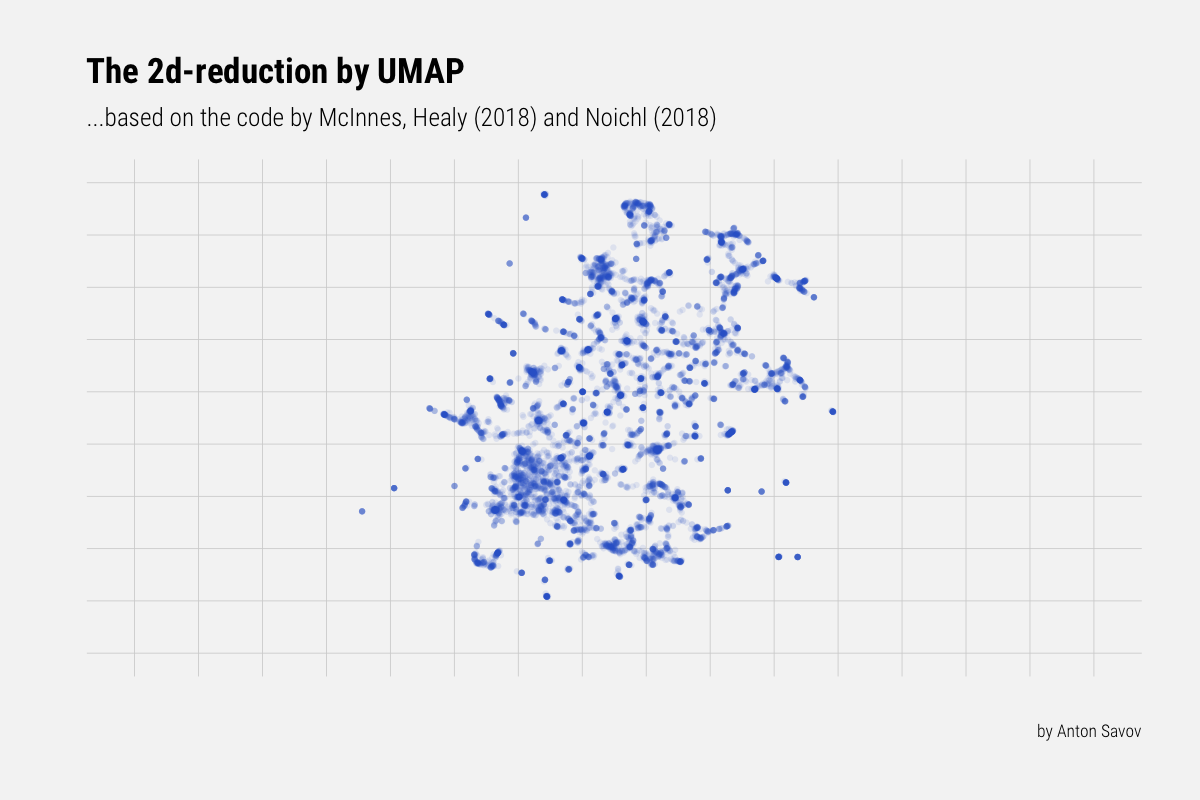

In [279]:
%%R -i embedding --width 1200 --height 800 -r 140 --bg #F5F5F5
library(hrbrthemes)
library(ggplot2)
library(fields)
embedding$density <- fields::interp.surface(
  MASS::kde2d(embedding$x, embedding$y), embedding[,c("x","y")])

p <- ggplot(embedding, aes(x=embedding$x, y=embedding$y,alpha = 1/density))+

 guides(alpha=FALSE)+

geom_point(color="#3366cc", pch=16,cex=1.2)+ theme_ipsum_rc()+
labs(x="", y="",
       title="The 2d-reduction by UMAP",
       subtitle="...based on the code by McInnes, Healy (2018) and Noichl (2018)",
       caption="by Anton Savov")+
theme(panel.grid.major = element_line(colour = "lightgrey"),panel.grid.minor = element_blank())+

#comment out the next two lines to see the whole space with all the outliers
scale_x_continuous(limits=c(-25,25),labels=NULL, breaks=seq(-25,25,length=16))+
scale_y_continuous(limits=c(-15,15),labels=NULL, breaks=seq(-15,15,length=10))+

NULL
p

## Clustering
For the clustering we use [HDBSCAN](https://github.com/scikit-learn-contrib/hdbscan).
The `clustersize` variable needs to be adjusted based on the number of papers in the data set. For me and my collection of 12,000 records a number between 100 and 200 worked well.

It is important to note that the process of embedding into two dimensions with UMAP is stochastic, i.e. non-deterministic. In plain text that means that each time we run it it will produce slightly different results even though we use the same data. This also has influence on the clustering. In one of the runs I did a cluster size of 100 split the map into 24 clusters, in the next run the same data and cluster size resulted in 17 clusters. So bare that in mind when judging the final result presented here and also if you use this method to produce your own maps.

In [144]:
try:
    drc = drc.drop('cluster',axis=1)
except KeyError:
    pass

import hdbscan

#(min_cluster_size=500, min_samples=30, gen_min_span_tree=True)
#clusterer = hdbscan.HDBSCAN(min_cluster_size=455, min_samples=35, gen_min_span_tree=True)

#adjust this number based on number of papers in your data set
clustersize = 140

clusterer = hdbscan.HDBSCAN(min_cluster_size=clustersize, min_samples=50, gen_min_span_tree=True)
clusterer.fit(embedding)
XCLUST = clusterer.labels_
clusternum = len(set( clusterer.labels_))-1


dfclust = pd.DataFrame(XCLUST)
dfclust.columns = ['cluster']

print(clusternum)
### Let's play a little sound when we're done:
#import winsound
#winsound.Beep(550,300)

17


Now lets plot the map and the clusters in `ggplot`:

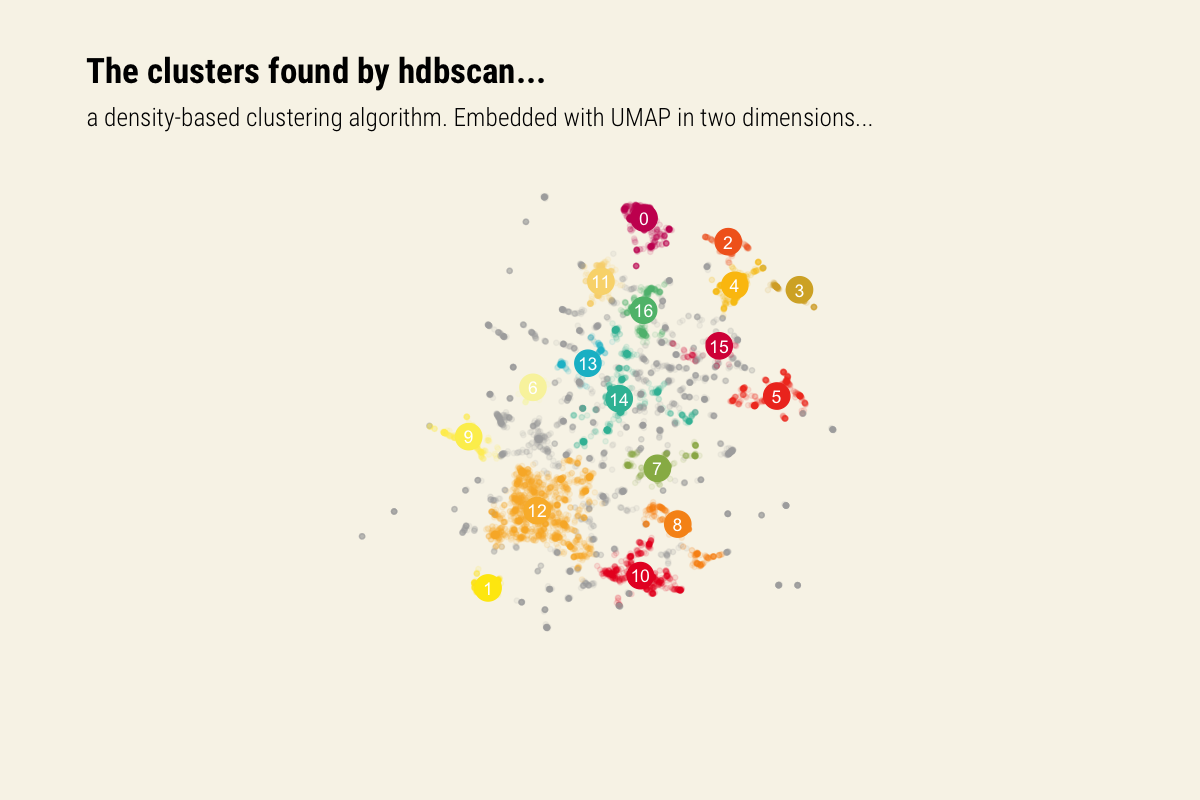

In [280]:
%%R -i embedding,dfclust -o myNewColors --width 1200 --height 800 -r 140 --bg #F8F4E9

# --bg #231f20

library(hrbrthemes)
library(ggplot2)
library(fields)
library(plyr)
options(warn=0)# 0 zum anschalten

#Get the cluster means:
means <- aggregate(embedding[,c("x","y")], list(dfclust$cluster), median)
means <- data.frame(means) 
n=nrow(means)
means <- means[-1,]

#good place to try get consistent colors is http://colorbrewer2.org/
#Make the colors: 
mycolors <- c("#6abc70", "#0abcce", "#f9f4b8", "#ffe800", "#fbab19", "#f68121", "#ed1c24", "#ca205f") 

pal <- colorRampPalette(sample(mycolors))
s <- n-1
myGray <- c('#aaaaaa')
myNewColors <- sample(pal(s))
myPal <- append(myGray,myNewColors)


#get density, to avoid overplotting
embedding$density <- fields::interp.surface(
  MASS::kde2d(embedding$x, embedding$y), embedding[,c("x","y")])

p <- ggplot(embedding, aes(x=embedding$x, y=embedding$y, color= as.factor(dfclust$cluster), alpha = 1/density))+
geom_point(pch=20,cex=1.6)+ 
theme_ipsum_rc()+
scale_color_manual(values = myPal) +
 guides(alpha=FALSE, color=FALSE)+
geom_point(data=means, aes(x=means$x, y=means$y), color= myNewColors, alpha = 1,size =6)+
#annotate("text", x = means[,c("x")], y = means[,c("y")], label = means[,c("Group.1")], color="white", fontface="bold",  size=3.2, parse = TRUE, hjust=0.5)+
annotate("text", x = means[,c("x")], y = means[,c("y")], label = means[,c("Group.1")], color="white", fontface="bold",  size=3.2, parse = TRUE, hjust=0.5)+
labs(x="", y="",
       title="The clusters found by hdbscan...",
       subtitle="a density-based clustering algorithm. Embedded with UMAP in two dimensions...")+
theme(panel.grid.major = element_line(colour = "lightgrey", size=0),panel.grid.minor = element_blank())+
#theme(panel.grid.major = element_blank(),panel.grid.minor = element_blank())

#comment out the next two lines to see the whole space with all the outliers
scale_x_continuous(limits=c(-25,25),labels=NULL, breaks=seq(-25,25,length=16))+
scale_y_continuous(limits=c(-15,15),labels=NULL, breaks=seq(-15,15,length=10))+

NULL

p

#pdf("ClusteringUMap.pdf", width = 12, height = 12) # Open a new pdf file
#print(p) #write the plot to the PDF
#dev.off() #close the PDF

## Tree of cluster similarity

Now that we have the clusters we can look at which clusters are more similar to each other by taking a look at when did the algorithm found it necessary to split a group into two.
In the chart below, the sooner a cluster broke off of the main trunk, the more disconnected are the articles it contains from the rest of the research body.

The clusters are numbered and later we will analyse the content of each cluster so you can scroll down to the labels to check what body of work is in each cluster.

My observation is that "Shape Grammars" are usually the first cluster to split from the bulk, so probably it means they are the most distinguishable in terms of the features we use (cited authors and cited works) from every other research topic in digital design in architecture.

In general it is interesting to observe in this tree where things split from each other. If we take shape grammars out then what is the next most distinguishable field of research?

### Colours
Next we will generate colours for the cluster from a gradient pallette using the cluster id or the lambda value of when it split off from the main trunk as a sampling variable.

In [231]:
#define cluster colours by split lambda value
tree = clusterer.condensed_tree_.to_pandas()
cluster_tree = tree[tree.child_size > 1]
#display(cluster_tree)
from matplotlib import cm
from matplotlib.colors import to_hex

#the reference for the built in linear color maps in matplotlib is at:
#  https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html 
#cluster_gradient = cm.cool
#cluster_gradient = cm.rainbow
#cluster_gradient = cm.gist_rainbow
#cluster_gradient = cm.jet

#cluster_gradient = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#4D3E71","#7D4495","#AB5596","#DA6688","#F88F79","#FCC696"])
cluster_gradient = matplotlib.colors.LinearSegmentedColormap.from_list(
    "",
    ["#FCC696","#F88F79","#DA6688","#AB5596","#7D4495","#4D3E71"]
)
#cluster_gradient = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#009392","#39b185","#9ccb86","#e9e29c","#eeb479","#e88471","#cf597e"])
#cluster_gradient = cm.hsv

#get the node ids of the clusters
chosen_clusters = clusterer.condensed_tree_._select_clusters()

#get the condensed cluster tree
tree = clusterer.condensed_tree_.to_numpy()
cluster_tree = [x for x in tree if x[3]>1]
#display(cluster_tree)

lambda_vals = [x[2] for x in cluster_tree if x[1] in chosen_clusters]
#display(lambda_vals)

from scipy.interpolate import interp1d
m = interp1d([min(lambda_vals),max(lambda_vals)],[0,1])
#print(m(lambda_vals[1]))
#print(to_hex(cluster_gradient(.5)))
my_cluster_colours = [to_hex(cluster_gradient(m(x))) for x in lambda_vals]
#display(my_cluster_colours)

from rpy2 import robjects

my_cluster_colours_R = robjects.vectors.StrVector(my_cluster_colours)
#print(type(my_cluster_colours_R))
#display(my_cluster_colours_R)

In [7]:
#or, alterntatively, define colors by cluster numbers
from matplotlib import cm
from matplotlib.colors import to_hex, LinearSegmentedColormap

#cluster_gradient = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#4D3E71","#7D4495","#AB5596","#DA6688","#F88F79","#FCC696"])
cluster_gradient = LinearSegmentedColormap.from_list(
    "",
    ["#FCC696","#F88F79","#DA6688","#AB5596","#7D4495","#4D3E71"]
)
#cluster_gradient = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#009392","#39b185","#9ccb86","#e9e29c","#eeb479","#e88471","#cf597e"])
#cluster_gradient = cm.hsv

eqspace = np.linspace(0.0, 1.0, num=17)
my_cluster_colours_2 = [to_hex(cluster_gradient(x)) for x in eqspace]
display(my_cluster_colours_2)

['#fcc696',
 '#fbb58d',
 '#f9a384',
 '#f8927b',
 '#f0857d',
 '#e77882',
 '#de6b86',
 '#d1638b',
 '#c25d8f',
 '#b35894',
 '#a55396',
 '#964d96',
 '#884895',
 '#794492',
 '#6a4287',
 '#5b407c',
 '#4d3e71']

Next let's use `SankeyWidget`to plot the cluster tree:

In [232]:
from ipysankeywidget import SankeyWidget
from ipywidgets import Layout
from IPython.display import (
    Image,
    SVG
)

parent_nodes = [x[0] for x in cluster_tree]

links = []
cluster_nodes =[]
nodes = []
removed_parent_nodes = []

first_node = min(parent_nodes)
node = {'id': first_node, 'title': 'All articles' }
nodes.append(node)

for edge in cluster_tree:
    if edge[0] in chosen_clusters or edge[0] in removed_parent_nodes:
         #filter out leaves that didn't get selected as a cluster
        removed_parent_nodes.append(edge[1])
    else:
        if edge[1] in chosen_clusters:
            #this is a cluster leaf so set label, color, etc
            cluster_id = chosen_clusters.index(edge[1])
            cluster_label = "cluster " + str(cluster_id)
            color = my_cluster_colours[cluster_id]
            cluster_nodes.append(edge[1])
            node = {'id': edge[1], 'title': cluster_label, 'style': 'process' }
        else:
            #this is a branch so use default color and remove label
            color = '#16457D' #"#bfc4c6"
            node = {'id': edge[1], 'title': '' }
        nodes.append(node)
        link = {
            'source':edge[0],
            'target':edge[1],
            'value':edge[3],
            'color':color
        }
        links.append(link)
    
#display(links)
#display(cluster_nodes)

#use the rank_sets to place all cluster leafs on the same line
rank_sets = [
    { 'type': 'same', 'nodes': cluster_nodes }
]

#use the order to force order by splitting event
#to use pass order=order in the arguments of SankeyWidget
#It creates kind of a wavey chart so I decided not to use it
'''
sorted_nodes = []
for edge in cluster_tree:
    for i in [0,1]:
        if not edge[i] in removed_parent_nodes and not edge[i] in sorted_nodes:
            sorted_nodes.append(edge[i])
order = []
for node in sorted(sorted_nodes):
    order.append([node])
'''

#sankey = SankeyWidget(links=links, rank_sets=rank_sets, nodes=nodes, layout=Layout(width="2400", height="400")).auto_save_png('test.png')
sankey = SankeyWidget(links=links, nodes=nodes, layout = Layout(width="1920", height="300")).auto_save_svg('exports/cluster_tree.svg')
sankey

#SVG(sankey.svg)
#sankey.save_svg('test.svg')

SankeyWidget(layout=Layout(height='300', width='1920'), links=[{'source': 9779, 'target': 9780, 'value': 415, …

Here is the result of the last cell:
![Cluster Tree](images/cluster_tree.png)

## What is each cluster about?
Now, let's figure out what body or work does each cluster contain. Lets look at the common words, the cited works and authors for each cluster. 

### The most common words and phrases
We can analyze the titles and the abstract of the articles in a cluster and derive the most common words and phrases. Since in the field there are established threee-word-terms such as "Building Information Modeling" it makes sense to look for the most common 

And since some article records don't have the abstract info in the data we downloaded from WOS we will do this analysis separate for the titles and the abstract. Plus the abstract have much more words than the titles so their content will drown whatever the titles are about.

But before we do any text analysis lets unify the spelling differences between US and UK English such as "modeling" and "modelling". And we will also remove the most common words such as "paper", as well as the terms that are common accross all clusters such as "design".

In [108]:
drc = pd.concat([drc, dfclust],axis=1)
drc = drc.dropna(subset=['cluster'])
drc = pd.concat([drc, embedding],axis=1)

In [109]:
#load up the UK to US spelling dictionary
#the list of words is taken from http://www.tysto.com/uk-us-spelling-list.html
#import random
uk2us = {}
with open('data/uk-to-us-dict.csv', 'r') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=';')
    for row in spamreader:
        ukword = row[0].replace(" ", "")
        usword = row[1].replace(" ", "")
        uk2us[ukword] = usword
#print(uk2us[random.choice(list(uk2us.keys()))])

#this function will replace words that are keys in mydict with the corresponding value
def replace_all(text, mydict):
    for gb, us in mydict.items():
        #text = text.replace(us, gb)
        text = re.sub(r"\b%s\b" % re.escape(gb) , us, text)
    return text

In [110]:
#kick out common abstract words of no importance
removeWords = ['|','paper','argue','account','theory',
                'elsevier','reserved','rights',
                'used','use','new','using',
                'copyright', 'published']

In [111]:
#builds the text bag for each cluster for a given tag
def buildTextBags(drcval, replacedict, removelist, tag, clean=True):
    fullstrsl = []
    

    #build a map of the words to remove for later
    big_regex = re.compile(r'\b%s\b' % r'\b|\b'.join(map(re.escape, removelist)))
    for x in range(0,clusternum):
        textBag = list(drcval.loc[drcval['cluster'] == x][tag])
        #titles = list(drc.loc[drc['cluster'] == x]['title'])
        #abstracts = abstracts + titles
        #abstracts = ";".join(str(x) for x in abstracts).replace('|',' ').replace('paper',' ').replace('argue',' ').replace('account',' ').replace('theory',' ').replace('elsevier',' ').replace('reserved',' ').replace('rights',' ').replace('used',' ').replace('use',' ').replace('new',' ').replace('using',' ').replace('process',' ').replace('approach',' ') #kick out common abstract words of no importance
        textBag = ";".join(str(x) for x in textBag) 
        if clean:
            textBag = big_regex.sub(" ", textBag)#kick out common abstract words of no importance
        #use the word replacing code here https://bytes.com/topic/python/answers/795690-replacing-string-words-list#post3162180
        textBag = replace_all(textBag, replacedict) #this slows things down
        fullstrsl.append(textBag)
    #print(fullstrsl[0][:50])
    return fullstrsl

#build the bags - kind of slow for the abstracts 
clusterTextBagsTitles = buildTextBags(drc, uk2us, removeWords, 'title')
clusterTextBagsAbstracts = buildTextBags(drc, uk2us, removeWords, 'abstract')

In [112]:
#check if a string searchfor exists in 'searchin' only as a whole word/phrase
def string_found(searchfor, searchin):
    return re.search(r'\b%s\b' % (re.escape(searchfor)), searchin) is not None

#if a phrase is found in a longer phrase reduce its score with the score of hte longer phrase
#exclude if true the word score is set to 0 if exclude is false then the longer word score is subtracted from short word score
def accountScores(longphrasescores, shortphrasescores, exclude=True):
    newscores =[]
    for phrase in shortphrasescores:
        newphraseScore = [phrase[0],phrase[1]]
        for longphrase in longphrasescores:
            #if phrase is found in longphrase subtract scores
            #pat = re.compile(r"\b%s\b" % re.escape(phrase[0]))
            #print(phrase[0])
            
            if string_found(phrase[0], longphrase[0]):
                if exclude:
                    newphraseScore[1] = 0
                else:                      
                    newphraseScore[1] = phrase[1]-longphrase[1]
        newscores.append(newphraseScore)
    return newscores

#this def below is not needed anymore
def accountScoreClusters(longscores, shortscores):
    counter =0
    newclusterscores =[]
    for cluster in shortscores:
        newclusterscores.append(accountScores(longscores[counter],cluster))
        counter +=1
    return newclusterscores

In [113]:
#tag is which tag('abstract' or 'title') to analyze for
#phrase is the phrase length in words. use 2 for bigrams;
#n is how many words to output
#treshold is the minimum number of occurences needed to include the word
#clean if True will skip the words in the removeWords list
#longphrasescores is a list of pairs
#           first item is scorelist for already ranked words/phrases
#           second item if true the word score is set to 0 if exclude is false then the longer word score is subtracted from short word score
#longphrasescores is used for example to reduce the score of the bigram "building information" with the score of the trigram "building information modeling", i.e. to avoid double counting
def rankWords(textBag,phrase=1, n=10,treshold=10, longphrasescores=None):
    
    
    vec = CountVectorizer( stop_words='english', ngram_range=(phrase, phrase))#Choose CountVectorizer for the most common words in the cluster, TfidfVectorizer for the words with the greatest differentiation value.
    X = vec.fit_transform(textBag)
    #print(pd.DataFrame(X.toarray(), columns=vec.get_feature_names())) #To look into the vectors. Beware, can take a bit of RAM
    
    
    clusterfeatures = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
    fullscore = []
    for x in range(0,clusternum):
        scores = zip(vec.get_feature_names(), np.asarray(X[x,:].sum(axis=0)).ravel())
        
        accountedScores = sorted(scores, key=lambda x: x[1], reverse=True)
        accountedScores = accountedScores[0:60]
        #subtract scores if phrase is found in longphrasescores
        if longphrasescores is not None:            
            for longphrasescore in longphrasescores:
                accountedScores = accountScores(longphrasescore[0][x], accountedScores,longphrasescore[1])
        #sort
        sorted_scores = sorted(accountedScores, key=lambda x: x[1], reverse=True)
        
        myscores = sorted_scores[0:n]
        #print(myscores)
        #print("___________________")
        scorelist = []
        counter = 0
        for s in myscores:
            #print(s)
            if s[1]>treshold or counter == 0:
                #newWord = s[0] + ' ('+str(s[1]) + ')' # do the word and the how often it comes
                newWord = [s[0],s[1]] # do the word and the how often it comes
                scorelist.append(newWord)
            #else:
            #    newWord = 'x' # skip the word if it appears less than 10 times
            
            counter += 1
        fullscore.append(scorelist)
    return fullscore

#adds to dataframes of scores for one cluster together
def addClusterScores(score1,score2):
    newscore = []
    for clusterid in range(0,len(score1)):
        clusterscore =[]
        for item in score1[clusterid]:
            clusterscore.append(item)
        for item in score2[clusterid]:
            clusterscore.append(item)   
        newscore.append(clusterscore)
    return newscore

In [114]:
print("TOP 5 TRIGRAMS ABSTRACTS")
trigramScoreAbstracts = rankWords(clusterTextBagsAbstracts,phrase=3)
display(pd.DataFrame(trigramScoreAbstracts).transpose().head())

print("TOP 5 TRIGRAMS TITLES")
trigramScoreTitles = rankWords(clusterTextBagsTitles,phrase=3,longphrasescores=[[trigramScoreAbstracts,True]])
display(pd.DataFrame(trigramScoreTitles).transpose().head())


print("TOP 5 TRIGRAMS COMBINED")
trigrams = addClusterScores(trigramScoreAbstracts,trigramScoreTitles)
display(pd.DataFrame(trigrams).transpose().head())


TRIGRAMS ABSTRACTS


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,"[shape grammar interpreter, 10]","[point cloud data, 17]","[space syntax analysis, 8]","[planning support systems, 10]","[cellular automata ca, 17]","[design digital fabrication, 10]","[building information modeling, 5]","[finite element analysis, 9]","[geometric constraint solving, 14]","[building information modeling, 106]","[finite element analysis, 10]","[architectural design process, 11]","[building information modeling, 64]","[human behavior simulation, 6]","[building information modeling, 8]","[analog digital notational, 2]","[creative conceptual design, 9]"
1,None,"[radio frequency identification, 16]",None,None,None,None,None,None,None,"[information modeling bim, 76]",None,None,"[information modeling bim, 47]",None,None,None,None
2,None,"[building information models, 13]",None,None,None,None,None,None,None,"[industry foundation classes, 30]",None,None,"[tool path generation, 39]",None,None,None,None
3,None,"[precast concrete elements, 12]",None,None,None,None,None,None,None,"[architecture engineering construction, 24]",None,None,"[support vector machine, 29]",None,None,None,None
4,None,"[building information modeling, 11]",None,None,None,None,None,None,None,"[building information models, 22]",None,None,"[computer aided design, 18]",None,None,None,None
5,None,None,None,None,None,None,None,None,None,"[foundation classes ifc, 21]",None,None,"[genetic algorithm ga, 17]",None,None,None,None
6,None,None,None,None,None,None,None,None,None,"[semantic web technologies, 14]",None,None,"[particle swarm optimization, 16]",None,None,None,None
7,None,None,None,None,None,None,None,None,None,"[building information model, 11]",None,None,"[finite element analysis, 15]",None,None,None,None
8,None,None,None,None,None,None,None,None,None,"[bv building information, 11]",None,None,"[experimental results demonstrate, 14]",None,None,None,None
9,None,None,None,None,None,None,None,None,None,"[engineering construction aec, 11]",None,None,"[finite element method, 14]",None,None,None,None


TRIGRAMS TITLES


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,"[early stages design, 3]","[3d laser scanning, 4]","[urban street networks, 3]","[positive theory planning, 3]","[agent based modeling, 6]","[building information modelling, 3]","[design process planning, 2]","[algorithm automatic 2d, 2]","[geometric constraint systems, 6]","[building information modelling, 5]","[free form surfaces, 7]","[architectural design studio, 2]","[sculptured surface machining, 9]","[classicism new synthesis, 2]","[land use planning, 8]","[art net london, 2]","[case based design, 8]"


TRIGRAMS COMBINED


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,"[shape grammar interpreter, 10]","[point cloud data, 17]","[space syntax analysis, 8]","[planning support systems, 10]","[cellular automata ca, 17]","[design digital fabrication, 10]","[building information modeling, 5]","[finite element analysis, 9]","[geometric constraint solving, 14]","[building information modeling, 106]","[finite element analysis, 10]","[architectural design process, 11]","[building information modeling, 64]","[human behavior simulation, 6]","[building information modeling, 8]","[analog digital notational, 2]","[creative conceptual design, 9]"
1,"[early stages design, 3]","[radio frequency identification, 16]","[urban street networks, 3]","[positive theory planning, 3]","[agent based modeling, 6]","[building information modelling, 3]","[design process planning, 2]","[algorithm automatic 2d, 2]","[geometric constraint systems, 6]","[information modeling bim, 76]","[free form surfaces, 7]","[architectural design studio, 2]","[information modeling bim, 47]","[classicism new synthesis, 2]","[land use planning, 8]","[art net london, 2]","[case based design, 8]"
2,None,"[building information models, 13]",None,None,None,None,None,None,None,"[industry foundation classes, 30]",None,None,"[tool path generation, 39]",None,None,None,None
3,None,"[precast concrete elements, 12]",None,None,None,None,None,None,None,"[architecture engineering construction, 24]",None,None,"[support vector machine, 29]",None,None,None,None
4,None,"[building information modeling, 11]",None,None,None,None,None,None,None,"[building information models, 22]",None,None,"[computer aided design, 18]",None,None,None,None
5,None,"[3d laser scanning, 4]",None,None,None,None,None,None,None,"[foundation classes ifc, 21]",None,None,"[genetic algorithm ga, 17]",None,None,None,None
6,None,None,None,None,None,None,None,None,None,"[semantic web technologies, 14]",None,None,"[particle swarm optimization, 16]",None,None,None,None
7,None,None,None,None,None,None,None,None,None,"[building information model, 11]",None,None,"[finite element analysis, 15]",None,None,None,None
8,None,None,None,None,None,None,None,None,None,"[bv building information, 11]",None,None,"[experimental results demonstrate, 14]",None,None,None,None
9,None,None,None,None,None,None,None,None,None,"[engineering construction aec, 11]",None,None,"[finite element method, 14]",None,None,None,None


In [132]:
print("TOP 5 BIGRAMS ABSTRACTS")
bigramScoreAbstracts = rankWords(clusterTextBagsAbstracts,phrase=2, n=5,longphrasescores=[[trigrams,False]])
#bigramScoreAbstracts = accountScoreClusters(trigramScoreAbstracts, bigramScoreAbstracts)
display(pd.DataFrame(bigramScoreAbstracts).transpose().head())

print("TOP 5 BIGRAMS TITLES")
bigramScoreTitles = rankWords(clusterTextBagsTitles,phrase=2, n=5,longphrasescores=[[trigrams,False],[bigramScoreAbstracts,True]])
#print(bigramScoreTitles[:10])
#bigramScoreTitles = accountScoreClusters(trigramScoreTitles, bigramScoreTitles)
#print(bigramScoreTitles[:10])
display(pd.DataFrame(bigramScoreTitles).transpose().head())

print("TOP 5 BIGRAMS COMBINED")
bigrams = addClusterScores(bigramScoreAbstracts,bigramScoreTitles)
display(pd.DataFrame(bigrams).transpose().head())

TOP 5 BIGRAMS ABSTRACTS


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,"[shape grammars, 119]","[construction sites, 55]","[space syntax, 65]","[spatial planning, 18]","[urban growth, 53]","[design process, 79]","[bim adoption, 13]","[solid model, 29]","[geometric constraint, 32]","[building information, 151]","[control points, 88]","[design process, 143]","[case study, 186]","[parametric design, 24]","[case study, 37]","[architectural design, 8]","[design process, 85]"
1,"[shape grammar, 110]","[construction site, 54]","[street network, 21]","[planning process, 13]","[cellular automata, 29]","[digital fabrication, 70]","[case study, 12]","[mesh generation, 27]","[point cloud, 29]","[construction industry, 44]","[bspline curve, 54]","[design processes, 49]","[proposed method, 182]","[architectural design, 17]","[design process, 28]",None,"[conceptual design, 68]"
2,"[design process, 34]","[point clouds, 42]","[spatial structure, 20]",None,"[landuse change, 28]","[computational design, 60]",None,"[case study, 22]","[boolean operations, 27]","[case study, 42]","[data points, 48]","[architectural design, 43]","[design process, 111]","[parametric modeling, 17]","[virtual reality, 23]",None,"[engineering design, 45]"
3,"[architectural design, 33]","[construction industry, 35]","[urban design, 19]",None,"[urban planning, 26]","[architectural design, 58]",None,"[product configuration, 21]","[data structure, 23]","[information modeling, 32]","[curves surfaces, 45]","[design research, 33]","[tool path, 103]","[design process, 14]","[case studies, 22]",None,"[case study, 29]"
4,"[design space, 20]","[point cloud, 32]","[spatial configuration, 15]",None,"[urban design, 25]","[design fabrication, 46]",None,"[design process, 19]","[geometric constraints, 23]","[building design, 28]","[bezier curves, 39]","[design thinking, 31]","[construction industry, 98]","[case studies, 13]","[architectural design, 20]",None,"[design knowledge, 29]"


TOP 5 BIGRAMS TITLES


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,"[generative design, 11]","[real time, 15]","[analysis urban, 7]","[planning design, 6]","[planning support, 17]","[robotic fabrication, 12]","[product data, 4]","[design rationale, 10]","[surface reconstruction, 14]","[bim based, 19]","[spline curves, 21]","[conceptual design, 10]","[real time, 28]","[design space, 5]","[computer aided, 8]","[modern architecture, 3]","[case based, 13]"
1,None,None,None,None,None,"[form finding, 11]",None,None,None,"[ontology based, 13]","[spline surfaces, 19]",None,"[construction projects, 18]",None,None,None,None
2,None,None,None,None,None,None,None,None,None,None,"[nurbs surfaces, 14]",None,"[path planning, 17]",None,None,None,None
3,None,None,None,None,None,None,None,None,None,None,"[subdivision surfaces, 14]",None,"[augmented reality, 16]",None,None,None,None
4,None,None,None,None,None,None,None,None,None,None,"[spline surface, 13]",None,"[based approach, 16]",None,None,None,None


TOP 5 BIGRAMS COMBINED


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,"[shape grammars, 119]","[construction sites, 55]","[space syntax, 65]","[spatial planning, 18]","[urban growth, 53]","[design process, 79]","[bim adoption, 13]","[solid model, 29]","[geometric constraint, 32]","[building information, 151]","[control points, 88]","[design process, 143]","[case study, 186]","[parametric design, 24]","[case study, 37]","[architectural design, 8]","[design process, 85]"
1,"[shape grammar, 110]","[construction site, 54]","[street network, 21]","[planning process, 13]","[cellular automata, 29]","[digital fabrication, 70]","[case study, 12]","[mesh generation, 27]","[point cloud, 29]","[construction industry, 44]","[bspline curve, 54]","[design processes, 49]","[proposed method, 182]","[architectural design, 17]","[design process, 28]","[modern architecture, 3]","[conceptual design, 68]"
2,"[design process, 34]","[point clouds, 42]","[spatial structure, 20]","[planning design, 6]","[landuse change, 28]","[computational design, 60]","[product data, 4]","[case study, 22]","[boolean operations, 27]","[case study, 42]","[data points, 48]","[architectural design, 43]","[design process, 111]","[parametric modeling, 17]","[virtual reality, 23]",None,"[engineering design, 45]"
3,"[architectural design, 33]","[construction industry, 35]","[urban design, 19]",None,"[urban planning, 26]","[architectural design, 58]",None,"[product configuration, 21]","[data structure, 23]","[information modeling, 32]","[curves surfaces, 45]","[design research, 33]","[tool path, 103]","[design process, 14]","[case studies, 22]",None,"[case study, 29]"
4,"[design space, 20]","[point cloud, 32]","[spatial configuration, 15]",None,"[urban design, 25]","[design fabrication, 46]",None,"[design process, 19]","[geometric constraints, 23]","[building design, 28]","[bezier curves, 39]","[design thinking, 31]","[construction industry, 98]","[case studies, 13]","[architectural design, 20]",None,"[design knowledge, 29]"


In [131]:

print("TOP 5 WORDS IN ABSTRACTS")
wordScoreAbstracts = rankWords(clusterTextBagsAbstracts,phrase=1, n=20, longphrasescores=[[trigrams,False],[bigrams,False]])
display(pd.DataFrame(wordScoreAbstracts).transpose().head())

print("TOP 5 WORDS IN TITLES")
wordScoreTitles = rankWords(clusterTextBagsTitles,phrase=1, n=20, longphrasescores=[[trigrams,False],[bigrams,False],[wordScoreAbstracts,True]])
display(pd.DataFrame(wordScoreTitles).transpose().head())

words = addClusterScores(wordScoreAbstracts,wordScoreTitles)
#display(pd.DataFrame(words).transpose())

ABSTRACTS


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,"[design, 655]","[construction, 491]","[urban, 208]","[planning, 281]","[urban, 437]","[design, 885]","[design, 167]","[design, 349]","[geometric, 236]","[bim, 419]","[surface, 596]","[design, 1539]","[design, 1520]","[design, 310]","[design, 521]","[design, 109]","[design, 945]"
1,"[shape, 271]","[data, 227]","[spatial, 196]","[design, 137]","[model, 388]","[fabrication, 285]","[model, 97]","[model, 191]","[method, 228]","[information, 402]","[surfaces, 454]","[designers, 310]","[construction, 1319]","[model, 65]","[model, 260]","[urban, 44]","[function, 198]"
2,"[grammar, 158]","[information, 166]","[analysis, 163]","[development, 67]","[planning, 214]","[research, 272]","[construction, 84]","[mesh, 178]","[model, 202]","[building, 374]","[curves, 431]","[study, 228]","[model, 1308]","[data, 58]","[data, 217]","[architecture, 42]","[knowledge, 161]"
3,"[rules, 140]","[method, 159]","[space, 135]","[urban, 63]","[spatial, 189]","[material, 249]","[data, 79]","[method, 172]","[surface, 180]","[design, 364]","[method, 387]","[research, 156]","[data, 1084]","[parametric, 56]","[process, 187]","[research, 39]","[model, 158]"
4,"[shapes, 113]","[safety, 156]","[design, 111]","[local, 60]","[models, 175]","[digital, 219]","[approach, 66]","[approach, 171]","[algorithm, 175]","[construction, 308]","[curve, 344]","[process, 143]","[method, 1064]","[approach, 52]","[approach, 186]","[process, 31]","[approach, 146]"


TITLES


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,"[architecture, 21]","[3d, 33]","[approach, 12]","[case, 12]","[based, 31]","[robotic, 23]","[systems, 13]","[modeling, 20]","[analysis, 21]","[based, 52]","[spline, 81]","[engineering, 21]","[simulation, 96]","[planning, 17]","[architecture, 28]","[new, 10]","[based, 41]"
1,"[language, 17]","[automated, 30]","[morphology, 11]",None,"[simulation, 22]","[systems, 21]","[simulation, 11]","[building, 14]","[cad, 20]","[analysis, 19]","[interpolation, 45]","[designing, 19]","[modeling, 86]","[urban, 12]","[decision, 22]",None,"[learning, 13]"
2,"[plans, 15]","[laser, 15]",None,None,"[cities, 18]","[performance, 19]",None,"[meshing, 14]","[3d, 19]","[architectural, 18]","[splines, 43]","[creative, 18]","[3d, 84]",None,"[modeling, 21]",None,"[planning, 13]"
3,"[implementation, 14]","[monitoring, 15]",None,None,"[gis, 17]","[parametric, 18]",None,"[3d, 12]","[solid, 19]","[automated, 16]","[approximation, 34]","[digital, 18]","[management, 77]",None,"[systems, 21]",None,"[reasoning, 13]"
4,"[planning, 14]","[bim, 14]",None,None,"[dynamics, 15]","[concrete, 15]",None,"[engineering, 12]","[surfaces, 19]","[performance, 16]","[modeling, 34]","[systems, 17]","[machining, 75]",None,"[simulation, 20]",None,"[urban, 13]"


In [130]:
#common words in the field to skip only in the single words lists
# ideally this should be automated to kick out all words that are occuring in more than 40-50% of clusters
commonFieldTerms = [
    'method', 'methods', 'process', 'design', 'designs',
    'research', 'based', 'approach',
    'information', 'architecture', 'architectural',
    'digital', 'development', 'building',
    'model', 'models', 'modeling',
    'result', 'results', 'study', 'data',
    'proposed', 'analysis', 'different',
    'space', 'spaces', 'spatial', 'bv'
]

def filterScoreList(scorelist, commonTerms):
    newscorelist = []
    for wscore in scorelist:
        #print(wscore)
        if not any(wscore[0] in s for s in commonTerms):
            newscorelist.append(wscore)
    return newscorelist


filteredwords = []
for wordscores in words:
    filteredwords.append(filterScoreList(wordscores, commonFieldTerms))
print("TOP 5 WORDS")
display(pd.DataFrame(filteredwords).transpose().head())

TOP 5 WORDS


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,"[shape, 271]","[construction, 491]","[urban, 208]","[planning, 281]","[urban, 437]","[fabrication, 285]","[construction, 84]","[mesh, 178]","[geometric, 236]","[bim, 419]","[surface, 596]","[designers, 310]","[construction, 1319]","[parametric, 56]","[construction, 172]","[urban, 44]","[function, 198]"
1,"[grammar, 158]","[safety, 156]","[patterns, 85]","[urban, 63]","[planning, 214]","[material, 249]","[developed, 52]","[configuration, 129]","[surface, 180]","[construction, 308]","[surfaces, 454]","[knowledge, 120]","[algorithm, 777]","[systems, 50]","[planning, 151]","[planning, 22]","[knowledge, 161]"
2,"[rules, 140]","[equipment, 132]","[movement, 68]","[local, 60]","[land, 109]","[construction, 207]","[planning, 48]","[algorithm, 121]","[algorithm, 175]","[project, 200]","[curves, 431]","[students, 118]","[surface, 661]","[performance, 46]","[urban, 150]","[physical, 21]","[product, 119]"
3,"[shapes, 113]","[tracking, 117]","[network, 65]","[plans, 53]","[city, 105]","[tools, 145]","[project, 43]","[knowledge, 112]","[set, 121]","[management, 173]","[curve, 344]","[cognitive, 113]","[developed, 626]","[tools, 46]","[project, 128]","[systems, 20]","[systems, 119]"
4,"[grammars, 91]","[workers, 106]","[properties, 62]","[performance, 48]","[systems, 104]","[structures, 137]","[framework, 38]","[construction, 100]","[constraints, 115]","[framework, 107]","[points, 269]","[problem, 100]","[performance, 558]","[designers, 43]","[problem, 123]","[cities, 16]","[functional, 106]"


Now let's combine all words and phrases into the cluster labels.

In [281]:
#import textwrap
allscores = addClusterScores(trigrams,bigrams)
allscores = addClusterScores(allscores,filteredwords)
display(allscores)
clusterlabels = []
clusterlabelsrows = []
clusterlabels_textblock = []
#clusterlabelsb = []
counter = 0
linelength = 140
for x in range(0,len(trigrams)):
    #clustertext = "TRIGRAMS: " + textwrap.fill("; ".join([ (w[0]+'('+str(w[1])+')') for w in trigrams[x] if w[1]>10 or trigrams[x].index(w)==0]),linelength) + '\n'
    #clustertext = clustertext + "BIGRAMS: " + textwrap.fill("; ".join([ (w[0]+'('+str(w[1])+')') for w in bigrams[x] if w[1]>10]),linelength)+ '\n'
    #clustertext = clustertext + "WORDS: " + textwrap.fill("; ".join([ (w[0]+'('+str(w[1])+')') for w in filteredwords[x] if w[1]>10]),linelength)
    trigramslabel =  "; ".join([ (w[0]+' ('+str(w[1])+'x)') for w in trigrams[x] if w[1]>10 ]) #and trigrams[x].index(w)<5])
    bigramslabel = "; ".join([ (w[0]+' ('+str(w[1])+'x)') for w in bigrams[x] if w[1]>10 ]) #and bigrams[x].index(w)<5])
    wordslabel = "; ".join([ (w[0]+' ('+str(w[1])+'x)') for w in filteredwords[x] if w[1]>10 ]) #and filteredwords[x].index(w)<20])
    #clustertext = "OFTEN USED TERMS: " + trigramslabel + ("; " if len(trigramslabel)>0 else "") + bigramslabel + ("; " if len(bigramslabel)>0 else "") + wordslabel
    clustertext = trigramslabel + ("; " if len(trigramslabel)>0 else "") + bigramslabel + ("; " if len(bigramslabel)>0 else "") + wordslabel
    clusterlabels_textblock.append(clustertext)
    clustertext = textwrap.fill(clustertext,linelength) 
    clusterlabels.append(clustertext)
    #this is how many lines are in this cluster's label
    clusterlabelsrows.append(len(clustertext.split('\n')))
    #clusterlabelsb.append("")
    print("cluster: " + str(counter))
    #print(textwrap.fill(clustertext,70))
    print(clustertext)
    print("--------------------")
    counter +=1
display(pd.DataFrame(clusterlabels_textblock))
#print(clusterlabels)
#display(clusterlabels_textblock)

[[['shape grammar interpreter', 10],
  ['early stages design', 3],
  ['shape grammars', 119],
  ['shape grammar', 110],
  ['design process', 34],
  ['architectural design', 33],
  ['design space', 20],
  ['generative design', 11],
  ['shape', 271],
  ['grammar', 158],
  ['rules', 140],
  ['shapes', 113],
  ['grammars', 91],
  ['generation', 74],
  ['presented', 73],
  ['systems', 70],
  ['language', 17],
  ['plans', 15],
  ['implementation', 14],
  ['planning', 14],
  ['formal', 13],
  ['layout', 13],
  ['representation', 13],
  ['computer', 12],
  ['floor', 12],
  ['urban', 12],
  ['generative', 11]],
 [['point cloud data', 17],
  ['radio frequency identification', 16],
  ['building information models', 13],
  ['precast concrete elements', 12],
  ['building information modeling', 11],
  ['3d laser scanning', 4],
  ['construction sites', 55],
  ['construction site', 54],
  ['point clouds', 42],
  ['construction industry', 35],
  ['point cloud', 32],
  ['real time', 15],
  ['constructio

cluster: 0
shape grammars (119x); shape grammar (110x); design process (34x); architectural design (33x); design space (20x); generative design (11x);
shape (271x); grammar (158x); rules (140x); shapes (113x); grammars (91x); generation (74x); presented (73x); systems (70x); language (17x);
plans (15x); implementation (14x); planning (14x); formal (13x); layout (13x); representation (13x); computer (12x); floor (12x); urban
(12x); generative (11x)
--------------------
cluster: 1
point cloud data (17x); radio frequency identification (16x); building information models (13x); precast concrete elements (12x); building
information modeling (11x); construction sites (55x); construction site (54x); point clouds (42x); construction industry (35x); point cloud
(32x); real time (15x); construction (491x); safety (156x); equipment (132x); tracking (117x); workers (106x); management (98x); project
(93x); technology (87x); 3d (33x); automated (30x); laser (15x); monitoring (15x); bim (14x); contro

,0
0,shape grammars (119x); shape grammar (110x); d...
1,point cloud data (17x); radio frequency identi...
2,space syntax (65x); street network (21x); spat...
3,spatial planning (18x); planning process (13x)...
4,cellular automata ca (17x); urban growth (53x)...
5,design process (79x); digital fabrication (70x...
6,bim adoption (13x); case study (12x); construc...
7,solid model (29x); mesh generation (27x); case...
8,geometric constraint solving (14x); geometric ...
9,building information modeling (106x); informat...


### What are the most cited papers in each cluster
Next we find the most cited papers for each cluster. This will give us the seminal works that everyone working that field always refers to. For example in the Shape Grammars cluster we have the [The Palladian Grammar](https://journals.sagepub.com/doi/abs/10.1068/b050005) by Stiny and Mitchel from 1978.

In [129]:
#THIS WILL GET US THE TOP CITED PAPERS PER CLUSTER
#fullstrsl = []
citationsDict = [None]*clusternum #per cluster
fullscoreTopCitations = []

for x in range(0,clusternum):
    
    citations = list(drc.loc[drc['cluster'] == x]['citestring'])
    citationsDict[x] = {}
    citations = [item for sublist in citations for item in sublist]
    for citation in citations:
        if not citation in citationsDict[x]:
            citationsDict[x][citation] = [citation,1]
        else:
            citationsDict[x][citation][1] += 1
    
    #
    rankedCitations = []
    for citation in citationsDict[x]:
        rankedCitations.append([citationsDict[x][citation][0],citationsDict[x][citation][1]])
   
    sorted_scores = sorted(rankedCitations, key=lambda x: x[1], reverse=True)
    myscores = sorted_scores[0:5]
    
    scorelist = []
    for s in myscores:
        if s[1] > 1:
            scorelist.append( [s[0],s[1]]) # do the word and the how often it comes)
            #scorelist.append(s[0]+ ' ('+str(s[1]) + ')') # do the word and the how often it comes)
    fullscoreTopCitations.append(scorelist)


    
print("TOP 5 CITATIONS")
display(pd.DataFrame(fullscoreTopCitations).transpose().head())

TOP 5 CITATIONS


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,"[STINY G, 1978, ENVIRON PLANN B, V5, P5, DOI 1...","[Tang PB, 2010, AUTOMAT CONSTR, V19, P829, DOI...","[Hillier B, 1984, SOCIAL LOGIC SPACE, 116]","[Alexander C., 1964, NOTES SYNTHESIS FORM, 20]","[Clarke KC, 1997, ENVIRON PLANN B, V24, P247, ...","[Gramazio Fabio, 2008, DIGITAL MAT ARCHITEC, 33]","[SMITH BM, 1983, IEEE COMPUT GRAPH, V3, P78, D...","[Mittal S., 1989, P 11 INT JOINT C ART, P1395,...","[Requicha A.A.G., 1982, ACM COMPUT SURV, V12, ...","[Eastman C, 2011, BIM HDB GUIDE BUILDI, 53]","[Piegl L., 1997, NURBS BOOK, 85]","[Schon D, 1983, REFLECTIVE PRACTITIO, 110]","[CHOI BK, 1998, SCULPTURED SURFACE M, 38]","[Woodbury R, 2010, ELEMENTS PARAMETRIC, 30]","[Keeney R. L., 1976, DECISIONS MULTIPLE O, 18]","[FOX Michael, 2009, INTERACTIVE ARCHITEC, 8]","[GERO JS, 1990, AI MAG, V11, P26, 48]"
1,"[STINY G, 1980, ENVIRON PLANN B, V7, P343, DOI...","[Bosche F, 2010, ADV ENG INFORM, V24, P107, DO...","[BENEDIKT ML, 1979, ENVIRON PLANN B, V6, P47, ...","[Forester J., 1989, PLANNING FACE POWER, 20]","[WHITE R, 1993, ENVIRON PLANN A, V25, P1175, D...","[Kolarevic B, 2005, PERFORMATIVE ARCHITE, 28]","[Smith SD, 1999, J CONSTR ENG M ASCE, V125, P1...","[MITTAL S, 1990, PROCEEDINGS : EIGHTH NATIONAL...","[Mantyla M., 1988, INTRO SOLID MODELING, 32]","[Eastman C., 2008, BIM HDB GUIDE BUILDI, 52]","[Hoschek J, 1993, FUNDAMENTALS COMPUTE, 56]","[Dorst K, 2001, DESIGN STUDIES, V22, P425, DOI...","[PERSSON H, 1978, COMPUT AIDED DESIGN, V10, P1...","[Woodbury RF, 2006, AI EDAM, V20, P63, DOI 10....","[MILLER GA, 1956, PSYCHOL REV, V63, P81, DOI 1...","[Harvey D., 1989, CONDITION POSTMODERN, 6]","[Hirtz J, 2002, RES ENG DES, V13, P65, DOI 10...."
2,"[KONING H, 1981, ENVIRON PLANN B, V8, P295, DO...","[Teizer J, 2010, AUTOMAT CONSTR, V19, P630, DO...","[Turner A, 2001, ENVIRON PLANN B, V28, P103, D...","[Healey P, 1996, ENVIRON PLANN B, V23, P217, D...","[Batty M., 1994, FRACTAL CITIES GEOME, 32]","[Kolarevic Branko., 2003, ARCHITECTURE DIGITAL...","[Smith L, 2010, ACTION RES-LONDON, V8, P407, D...","[BLACKER TD, 1991, INT J NUMER METH ENG, V32, ...","[HOFFMANN CM, 1989, GEOMETRIC SOLID MODE, 28]","[GRUBER TR, 1993, KNOWL ACQUIS, V5, P199, DOI ...","[De. Boor C., 1978, PRACTICAL GUIDE SPLI, 54]","[Goel V, 1995, SKETCHES THOUGHT, 54]","[LONEY GC, 1987, COMPUT AIDED DESIGN, V19, P85...","[Davis D, 2013, THESIS, 8]","[Cohon J. L., 1978, MULTIOBJECTIVE PROGR, 12]","[Graham S., 1996, TELECOMMUNICATIONS C, 5]","[Stone RB, 2000, J MECH DESIGN, V122, P359, DO..."
3,"[Stiny G., 1972, Information Processing 71 Pro...","[Song J, 2006, AUTOMAT CONSTR, V15, P166, DOI ...","[HILLIER B, 1993, ENVIRON PLANN B, V20, P29, D...","[ALEXANDER ER, 1989, ENVIRON PLANN B, V16, P12...","[Parker DC, 2003, ANN ASSOC AM GEOGR, V93, P31...","[Kolarevic B., 2008, MANUFACTURING MAT EF, 19]","[Shah J. J., 1994, ADV FEATURE BASED MA, 3]","[Sabin D, 1998, IEEE INTELL SYST APP, V13, P42...","[LIGHT R, 1982, COMPUT AIDED DESIGN, V14, P209...","[Eastman C, 2009, AUTOMAT CONSTR, V18, P1011, ...","[Faux I. D., 1979, COMPUTATIONAL GEOMET, 53]","[Cross N, 2007, BOARD INT RES DES, P1, DOI 10....","[SURESH K, 1994, J ENG IND-T ASME, V116, P253,...","[Newell A, 1972, HUMAN PROBLEM SOLVIN, 7]","[LYNCH K., 1960, IMAGE CITY, 11]","[Tafuri Manfredo, 1976, ARCHITECTURE UTOPIA, 5]","[Umeda Y, 1996, AI EDAM, V10, P275, DOI 10.101..."
4,"[Stiny G. N., 2006, SHAPE TALKING SEEING, 48]","[Bosche F, 2008, AUTOMAT CONSTR, V17, P499, DO...","[Hillier B, 1996, SPACE IS MACHINE, 33]","[RITTEL HWJ, 1973, POLICY SCI, V4, P155, DOI 1...","[COUCLELIS H, 1985, ENVIRON PLANN A, V17, P585...","[Khoshnevis B, 2004, AUTOMAT CONSTR, V13, P5, ...","[CHANG TC, 1990, EXPERT PROCESS PLANN, 3]","[PRICE MA, 1995, INT J NUMER METH ENG, V38, P3...","[BOUMA W, 1995, COMPUT AIDED DESIGN, V27, P487...","[Eastman C.M., 1999, BUILDING PRODUCT MOD, 29]","[CATMULL E, 1978, COMPUT AIDED DESIGN, V10, P3...","[Cross N., 1996, ANAL DESIGN ACTIVITY, 44]","[Preparata F., 1985, COMPUTAT

### Most cited authors in a cluster

Besides the individual works it is also very revealing who defines and drives the research in each cluster if we get a list of the most cited authors. So let's do that next. Sometimes the same author is logged differently in the WOS database, for example "Gramazio Fabio" and "Gramazio F". So first we will unify the authors list and then count the most popular.

In [120]:
#cases for merging A to author B
#1. "gramazio fabio" and "gramazio f" or "knight t" and "knight tw"
#if both have two words, word[0] is same, word[1] has same first letter, name them with the longer second word

#2. "simon ha" and "simon h a"
#if A has 3 words (with 2nd and 3rd single letter)and B has 2 words (2nd of 2 letter) or vice versa and word[0] is same and word[1] same first letter and word[2] of the one who has it is same letter as the other one's word[1]'s second letter

#3. "stiny g" and "stiny g n"
##if A has 3 words (with 2nd and 3rd single letter)and B has 2 words (2nd of 1 letter) or vice versa and word[0] is same and word[1] same first letter

def mergeSameAuthors(authorscorelist):
    newscorelist = []
    mergedict = {}
    for author in authorscorelist:
        #print(author)
        if not 'none' in author[0] and not "".join(author[0].split()) == '':
            names = author[0].split()  
            #print(names)
            newscore = [author[0],author[1]]
            merged = False
            if not names[0] in mergedict:
                mergedict[names[0]] = []
                #print(newscore)
                #mergedict[names[0]].append(newscore)
            else:
                for i in range(0, len(mergedict[names[0]])):
                    existingnames = mergedict[names[0]][i][0].split()
                    if len(names) >= 2 and len(existingnames) >= 2:
                        #case 1. and 2. and 3. from above
                        if names[1][0] == existingnames[1][0]:
                            #print("merging: (" + author[0] + ") into (" + mergedict[names[0]][i][0]) + ")"
                            mergedict[names[0]][i][1] = mergedict[names[0]][i][1] + author[1]
                            merged = True
            if not merged:
                #print("appending: " + newscore[0])
                mergedict[names[0]].append(newscore)               
    for familynamelist in mergedict:
        #print(familynamelist)
        for author in mergedict[familynamelist]:
            #print(author)
            newscorelist.append(author)
    return newscorelist

In [128]:
fullstrsl = []
for x in range(0,clusternum):
    authors = list(drc.loc[drc['cluster'] == x]['citedAU'])
    
    authors = [item for sublist in authors for item in sublist]
    #authors = authors + list(drc.loc[drc['cluster'] == x]['author'])
    authors = " §".join(str(x) for x in authors)
    #print(authors[:50])
    #changed here from 2 to 0 because it otherwise combines different authors with same family name as one
    #especially important for chinese names where family name such as "wang" is very common
    #two thing can be done here
    #1. merge entries for same author when he is listed with full name and family plus initial
    #     such as "gramazio fabio" and "gramazio f"
    #2. merge entries for same author when he is listed with first initial joined and not
    #     such as "simon ha" and "simon h a"
    #3. (optional as it might be wrong to do it) merge entries when author is listed with one and then with two initial
    #     such as "stiny g" and "stiny g n"
    #this might be done as follows
    #authors = ' '.join( [w for w in authors.split() if len(w)>2] )
    authors = ' '.join( [w for w in authors.split()])# if len(w)>0] )
    #print(authors[:50])
    fullstrsl.append(authors)

#print(fullstrsl[1])
vec = CountVectorizer(token_pattern=r'[\s\w\.-]+(?=[$|§])')#Choose CountVectorizer for the most common words in the cluster, TfidfVectorizer for the words with the greatest differentiation value.
X = vec.fit_transform(fullstrsl)

clusterfeatures = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
fullscoreA = []
for x in range(0,clusternum):
    scores = zip(vec.get_feature_names(), np.asarray(X[x,:].sum(axis=0)).ravel())
    sorted_scores = sorted(scores, key=lambda x: x[1])
    #print(sorted_scores[0:6])
    sorted_scores = mergeSameAuthors(sorted_scores)
    #print(sorted_scores[0:6])
    sorted_scores = sorted(sorted_scores, key=lambda x: x[1], reverse=True)
    myscores = sorted_scores[0:10]
    
    scorelist = []
    for s in myscores:
        if s[1] > 1:
            scorelist.append( [s[0],s[1]]) # do the word and the how often it comes)
            #scorelist.append(s[0]+ ' ('+str(s[1]) + ')') # do the word and the how often it comes)
    fullscoreA.append(scorelist)
print("TOP 5 CITED AUTHORS")
display(pd.DataFrame(fullscoreA).transpose().head())

TOP CITED AUTHORS


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,"[stiny gn , 356]","[teizer j , 85]","[hillier bill , 176]","[alexander ch , 62]","[batty ma , 243]","[kolarevic branko , 113]","[smith r t , 25]","[lee j i , 51]","[requicha a a , 140]","[eastman c a , 239]","[piegl les , 236]","[schon d-a , 259]","[choi bi , 131]","[woodbury r f , 53]","[mitchell wb , 30]","[jencks ca , 25]","[gero john s , 124]"
1,"[knight terry , 170]","[tang pf , 63]","[turner ak , 68]","[alexander eh , 59]","[white r n , 75]","[menges achim , 86]","[smith s l , 24]","[lee s j , 47]","[hoffmann ch , 104]","[gruber tb , 62]","[farin gerald e , 229]","[cross nigel , 232]","[lee s h , 125]","[simon h , 28]","[keeney ralph l , 28]","[rossi aldo , 22]","[pahl gerhard , 78]"
2,"[flemming u , 110]","[bosche fn , 63]","[batty ma , 67]","[healey p , 59]","[couclelis h , 57]","[gramazio f , 69]","[smith b m , 16]","[blacker t d , 33]","[rossignac jarek r , 77]","[sacks rafael , 47]","[sederberg thomas w , 151]","[lawson bryan , 132]","[chen y g , 118]","[davis db , 21]","[foley ja , 26]","[tafuri m , 22]","[goel ashok k , 73]"
3,"[march lj , 104]","[brilakis ik , 56]","[peponis john , 65]","[faludi andreas , 49]","[clarke k , 56]","[oxman r e , 59]","[smith g c , 16]","[lee k h , 29]","[hoppe hugues , 61]","[azhar salman , 43]","[hoschek j , 123]","[dorst kee , 117]","[wang wenping , 115]","[eastman c a , 19]","[saaty thomas l , 26]","[harvey david , 18]","[brown d m , 69]"
4,"[mitchell wb , 91]","[golparvar-fard mg , 53]","[benedikt m , 56]","[forester j , 44]","[wu fj , 55]","[hensel mu , 52]","[smith d m , 15]","[lee c h , 26]","[mantyla mj , 53]","[lee g s , 39]","[farouki ramt , 111]","[goldschmidt gabriela , 116]","[lee j -j , 111]","[akin o z , 17]","[simon hd , 26]","[alberti l , 16]","[maher m , 68]"


Great, now we have a list of authors for each cluster. Let's also count the number of articles per cluster

In [122]:
#this counts how many articles are in each cluster
articleCount = []
totalArticleCount = len(drc)
print(totalArticleCount)
for x in range(0,clusternum):
    articles = len(drc.loc[drc['cluster'] == x])
    articleCount.append(articles)
    print(articles)

9779
415
191
214
175
322
409
176
332
351
283
549
372
1851
211
623
175
312


Let's assemble the text for the sublabels for each cluster from the most cited works, most cited authors and the number of articles.

In [290]:
clusterlabelsb = []
clusterlabelsb_textblock = []
counter = 0
cluster_authors  = []
cluster_citations = []
linelength = 110
#fullscoreTopCitations
for x in range(0,len(fullscoreA)):
    articleCountText = str(articleCount[x]) + ' articles'
    authors = "\n".join( [ (w[0].split()[0].upper() + ',' + w[0].split()[1].upper()+' ('+str(w[1])+'x)') for w in fullscoreA[x]])
    cluster_authors.append(authors)
    clustertext = "MOST CITED AUTHORS: " + "; ".join( [ (w[0].split()[0].upper() + ',' + w[0].split()[1][0].upper()+'. ('+str(w[1])+'x)') for w in fullscoreA[x] ] )
    citations = "\n".join([ (w[0].upper() + ' ('+str(w[1])+'x)') for w in fullscoreTopCitations[x]])
    cluster_citations.append(citations)
    topcitationstext = "TOP CITATIONS: " + "; ".join([ (w[0].upper() + ' ('+str(w[1])+'x)') for w in fullscoreTopCitations[x]])+''
    #clustertext = clustertext + "Words: " + textwrap.fill("; ".join([ (w[0]+'('+str(w[1])+')') for w in filteredwords[x] if w[1]>10]),linelength)
    #clusterlabels[x] = clusterlabels[x]+ '\n' + clustertext
    clusterlabelsb_textblock.append(articleCountText + "\n" + clustertext + "\n" + topcitationstext)
    clustertext = textwrap.fill( clustertext,linelength)
    #clustertext = articleCountText + "\n" + clustertext + "\n" + textwrap.fill(topcitationstext,linelength) #.upper()
    clustertext = clustertext + "\n" + textwrap.fill(topcitationstext,linelength) #.upper()
    clusterlabelsb.append(clustertext)
    #clusterlabelsb.append("")
    print("cluster: " + str(counter))
    #print(textwrap.fill(clustertext,70))
    print(clustertext)
    print("--------------------")
    counter +=1
#display(clusterlabelsb_textblock)
display(cluster_authors)

cluster: 0
MOST CITED AUTHORS: STINY,G. (356x); KNIGHT,T. (170x); FLEMMING,U. (110x); MARCH,L. (104x); MITCHELL,W. (91x);
DUARTE,J. (86x); KRISHNAMURTI,R. (86x); GERO,J. (60x); COYNE,R. (59x); KONING,H. (57x)
TOP CITATIONS: STINY G, 1978, ENVIRON PLANN B, V5, P5, DOI 10.1068/B050005 (107x); STINY G, 1980, ENVIRON
PLANN B, V7, P343, DOI 10.1068/B070343 (92x); KONING H, 1981, ENVIRON PLANN B, V8, P295, DOI 10.1068/B080295
(54x); STINY G., 1972, INFORMATION PROCESSING 71 PROCEEDINGS OF THE IFIP CONGRESS 1971. VOLUME 2, P1460 (53x);
STINY G. N., 2006, SHAPE TALKING SEEING (48x)
--------------------
cluster: 1
MOST CITED AUTHORS: TEIZER,J. (85x); TANG,P. (63x); BOSCHE,F. (63x); BRILAKIS,I. (56x); GOLPARVAR-FARD,M.
(53x); SONG,J. (53x); CHENG,T. (52x); NAVON,R. (48x); AKINCI,B. (41x); ERGEN,E. (40x)
TOP CITATIONS: TANG PB, 2010, AUTOMAT CONSTR, V19, P829, DOI 10.1016/J.AUTCON.2010.06.007 (38x); BOSCHE F,
2010, ADV ENG INFORM, V24, P107, DOI 10.1016/J.AEI.2009.08.006 (33x); TEIZER J, 2010, AU

['STINY,GN (356x)\nKNIGHT,TERRY (170x)\nFLEMMING,U (110x)\nMARCH,LJ (104x)\nMITCHELL,WB (91x)\nDUARTE,JS (86x)\nKRISHNAMURTI,RAMESH (86x)\nGERO,JOHN (60x)\nCOYNE,RDD (59x)\nKONING,H (57x)',
 'TEIZER,J (85x)\nTANG,PF (63x)\nBOSCHE,FN (63x)\nBRILAKIS,IK (56x)\nGOLPARVAR-FARD,MG (53x)\nSONG,JB (53x)\nCHENG,T (52x)\nNAVON,R (48x)\nAKINCI,BURCU (41x)\nERGEN,E (40x)',
 'HILLIER,BILL (176x)\nTURNER,AK (68x)\nBATTY,MA (67x)\nPEPONIS,JOHN (65x)\nBENEDIKT,M (56x)\nLYNCH,KEVIN (40x)\nPENN,ALAN (35x)\nHANSON,JULIENNE (32x)\nRATTI,CARLO (31x)\nSTEADMAN,PA (29x)',
 'ALEXANDER,CH (62x)\nALEXANDER,EH (59x)\nHEALEY,P (59x)\nFALUDI,ANDREAS (49x)\nFORESTER,J (44x)\nINNES,JD (41x)\nFRIEND,J (34x)\nFRIEDMANN,J (29x)\nBERKE,P (23x)\nLINDBLOM,C (23x)',
 'BATTY,MA (243x)\nWHITE,R (75x)\nCOUCLELIS,H (57x)\nCLARKE,K (56x)\nWU,FJ (55x)\nKLOSTERMAN,R (49x)\nLANDIS,JR (48x)\nMANDELBROT,BENOIT (48x)\nTORRENS,PAUL (44x)\nWILSON,A (43x)',
 'KOLAREVIC,BRANKO (113x)\nMENGES,ACHIM (86x)\nGRAMAZIO,F (69x)\nOXMAN,R (59x)\

In [287]:
with open('exports/cluster_words.txt', 'w') as f:
    f.writelines("%s\n" % line for line in clusterlabels_textblock)

with open('exports/cluster_cited.txt', 'w') as f:
    f.writelines("%s\n" % line for line in clusterlabelsb_textblock)

## Plot the map

Finally we have all the information to plot the map of articles with the clusters and their labels. For plotting we use `ggplot2` from `R` as before. It gives us a raw-looking graphic but we can export as PDF and edit it further with Affinity Designer, Adobe Illustrator or Inkscape.

In [286]:
%%R -i embedding,dfclust,my_cluster_colours_R,clusterlabels,clusterlabelsb,journalListLabel -w 594 -h 420 --units mm -r 300 --bg #F5F5F2
#--bg #d3d3d3
#-o labelpol,cltest --bg #231f20
#-h 1600 -w 1600 -r 140 --bg #fbf8f1

# Some imports:
library(hrbrthemes)
library(ggplot2)
library(fields)
#library(ggrepel) #was off in original from Noichl, used for geom_label_repel
library(ggforce)
#install.packages('ggalt')
library(ggalt)
library(stringr)
#install.packages('clue')
#library(clue)



options(warn=0)# 0 zum anschalten

#Get the cluster means:
means <- aggregate(embedding[,c("x","y")], list(dfclust$cluster), mean)
means <- data.frame(means)

#And Variance, for the labels:
test <- aggregate(embedding[,c("x")], list(dfclust$cluster), var)
test <- test[-1,]

n=nrow(means)
means <- means[-1,]

#Make the colors: 
#mycolors <- c("#6abc70", "#0abcce", "#f9f4b8", "#ffe800", "#fbab19", "#f68121", "#ed1c24", "#ca205f") 
#mycolors <- c("#4eeadf","#e84a31","#cc2ee7","#bbe953","#50aeec")
#saturated from ColorBrewer
#mycolors <- c("#a6cee3","#1f78b4", "#b2df8a", "#33a02c", "#fb9a99", "#e31a1c", "#fdbf6f","#ff7f00", "#cab2d6","#6a3d9a", "#ffff99","#b15928")

#pastels from ColorBrewer
#mycolors <- c("#8dd3c7", "#ffffb3", "#bebada", "#fb8072", "#80b1d3", "#fdb462", "#b3de69", "#fccde5", "#d9d9d9", "#bc80bd", "#ccebc5", "#ffed6f")

#pal <- colorRampPalette(sample(mycolors))
s <- n-1
#myGray <- c('#858583') # c('#95a5a6') # for the points outside of a cluster

myGray <- c('#16457D') # ink blue
#myNewColors <- sample(pal(s))
myNewColors <- my_cluster_colours_R
myPal <- append(myGray,myNewColors)

labels <- clusterlabels            
#labelsrows <- clusterlabelsrows
labelsb <- clusterlabelsb  

#circular markers:  
library(gridExtra)

circle <- polygon_regular(100)
pointy_points <- function(x, y, size){
  do.call(rbind, mapply(function(x,y,size,id) 
    data.frame(x=size*circle[,1]+x, y=size*circle[,2]+y, id=id),
         x=x,y=y, size=size, id=seq_along(x), SIMPLIFY=FALSE))
}

#get density, to avoid overplotting
embedding$density <- 1/ as.numeric(fields::interp.surface(MASS::kde2d(embedding$x, embedding$y), embedding[,c("x","y")]))

# get for every label, whether it is in the + or - part of the x-axis:                        
xpol <-abs(means[,c("x")])/means[,c("x")]
ypol <-abs(means[,c("y")])/means[,c("y")]

polfact <- 1.5
 
#define label coordinates 
# build a circle for the labels:
r <- 14.5
sequence <- seq(from = 1, to = s, by = 1)
angles <- 360/s*sequence
angle <-(angles*(pi/180))
         
xlabl <- cos(angle)*r
ylabl <- sin(angle)*r
circlecord <- cbind(xlabl,ylabl)

labelpol <-abs(circlecord[,c("xlabl")])/circlecord[,c("xlabl")]

# install.packages("stringr")
# library(stringr)

#make the label coordinates on two lines left and right of the plot
halfclust = (s+1)%/%2
col1 <- data.frame(xlabl=rep(-15.5,halfclust),ylabl=seq(-13,13,length=halfclust))
col2 <- data.frame(xlabl=rep(15.5,s-halfclust),ylabl=seq(-13,13,length=s-halfclust))
linecoords <- rbind(col1,col2)

#make the label coordinates on one line on the right side of the plot
linecoords <- data.frame(xlabl=rep(20.5,s),ylabl=seq(-19.5,19.5,length=s))

circlecord <- linecoords

coord_x=5
coord_y=5
                        
# define circular markers:
circular_annotations <- pointy_points(means$x, means$y, size=test$x*0.25+1)
#
embedding <- cbind(embedding,dfclust)
filtered <- as.data.frame(subset(embedding, cluster >= 0))
cltest <- filtered

#Let's plot!
mapdotshape = 16 # originally this was 20 (circle with fill and border). with 3(cross symbol) it takes a lot of time to render
#this plots the points that belong to a cluster
p <- ggplot(data=filtered, aes(x=x, y=y, color= as.factor(cluster),alpha=0.5))+ #, alpha='density'))+
#pch=20 is bullet shape - https://stat.ethz.ch/R-manual/R-patched/library/graphics/html/points.html    
geom_point(pch=mapdotshape,cex=1.5)+#, alpha = 0/density)+ 
#scale_color_manual(values = myPal)+ #this applies our colours to the cluster points
scale_x_continuous(limits=c(-25,25),labels=NULL, breaks=seq(-25,25,length=16))+
scale_y_continuous(limits=c(-15,15),labels=NULL, breaks=seq(-15,15,length=10))+
#the lines below were disabled
#geom_polygon(data=circular_annotations, aes(x,y,group=factor(id), fill = factor(id)),alpha=0.15)+
#scale_fill_manual(values = myNewColors) #+      
#this hides the legends                        
#guides(alpha=FALSE, color=FALSE, fill=FALSE) #+
#
#this creates the coloured spots over the clusters that encircle them - takes time
#stat_density2d(n=800,h=c(1.1,1.1))
#
xlim(-15, 50) + 
ylim(-20, 20) + 
NULL
#end of the points plotting



#ggplot_build prepares the plot for rendering - https://ggplot2.tidyverse.org/reference/ggplot_build.html
#and also adds to p the coloured spots over the clusters by creating density contours around them
q <- ggplot_build(p+stat_density2d(n=400,h=c(1.1,1.1)))$data[[2]]
#looks like this filters out all points except those belonging to group 001 which is the first, outmost density contour 
#there is a problem because if first contour is comprised of several closed curves only one of them ends up being shown on the plot
q <- q[str_detect(q$group, "001") == TRUE, ]
# z <- max(test$x)
# print(z)

#this finds the point with minimum x for each cluster in the plot render data and gets its data in z
o <- aggregate(q$x, list(q$group) , min)
z <- subset(q,subset = q$x %in%  c(o$x))
#this finds the point with maximum x for each cluster in the plot render data and gets its data in zmax
omax <- aggregate(q$x, list(q$group) , max)
zmax <- subset(q,subset = q$x %in%  c(omax$x))

#this creates a dataframe with the points with min or max depending on which side of the origin each cluster lies
c <- data.frame()
count <- 1
for (val in xpol) {
if(val <0 ){
    c <- rbind(c, z[count,])
} else {
    c <- rbind(c, zmax[count,])
}
    count <- count + 1
}


#these are the x and y coords of those points (leftmost or right most per cluster)
#contactpoints <-  data.frame(c$x,c$y)
contactpoints <-  data.frame(zmax$x,zmax$y)

#Append every label to its best fit on that circle, using the hungarian algorithm:
require(clue)
#this gives all possible distances between the two sets of points, those on the circle and those in the cluster
distances <- rdist(circlecord,contactpoints)
#this give the indices of the points on the circle that fit closest to each cluster point
sol <- solve_LSAP(t(distances))
#this builds dataframe with the coordinates of each set of two matching points (cluster to circle)
solo <- data.frame(cbind(mx=(contactpoints[,1]), my=(contactpoints[,2]), cx=(circlecord[sol, 1]), cy=(circlecord[sol, 2])))
                        
xcpol <-abs(solo$cx)/solo$cx

#imprts the roboto condensed font for use in theme_ft_rc later
#import_roboto_condensed()
#import_titillium_web()

#this block produces the final graph using the one produced by p as the base
r <- 
p +
#this adds the points outside of a cluster
geom_point(data=subset(embedding, cluster == -1), aes(x=x, y=y),pch=mapdotshape,cex=1.5,alpha=0.5, color=myGray)+                      
#this draws the polygons blobby coloured spots around each cluster. it uses the precalculated data in q
#geom_polygon(data=q, aes(x,y ,group = as.factor(q$group),fill = as.factor(q$group)),alpha=0.3,linetype=1,size=0.6)+ # ,linetype=3, color="black"
#geom_polygon(data=q, aes(x,y ,group = as.factor(cluster),fill = as.factor(cluster)),alpha=0.3,linetype=1,size=0.6)+ # ,linetype=3, color="black"
#this draws the iso contours around the clusters in colour
stat_density2d(aes(colour=as.factor(cluster)),n=400,h=c(1.1,1.1),linetype=1,size=0.6,alpha=0.3)+#,color="black")+
#this draws the iso contours around the clusters in black
#stat_density2d(aes(colour="black"),n=400,h=c(1.1,1.1),linetype=1,size=0.6,alpha=0.3)+#,color="black")+
##scale_fill_manual(values = myPal)+
#this is a built in theme in hrbrthemes - https://www.rdocumentation.org/packages/hrbrthemes/versions/0.6.0/topics/theme_ipsum
theme_ipsum()+
#theme_ipsum_tw()+
#theme_modern_rc()+
## scale_fill_manual(values = myPal)
#this hides the legends
guides(alpha=FALSE, color=FALSE, fill=FALSE)+
#
labs(x=NULL, y=NULL, #x="UMAP-x", y="UMAP-y",
    title="DIGITAL DESIGN IN ARCHITECTURE",
    subtitle="RESEARCH LANDSCAPE MAP 1975-2019\nwith data from ~12,000 articles\nmapped by who cited who",
    caption=paste("BY ANTON SAVOV"))+   
#set parameters for the plot title
theme(plot.title = element_text(size=20, hjust = 0.5,colour = myGray))+ #, family="SC", face="plain"
#set parameters for the plot subtitle
theme(plot.subtitle = element_text(size=13, hjust = 0.5,colour = myGray))+ #, family="SC", face="plain"
#this modifies the grid lines
#theme(panel.grid.major = element_line(colour = "grey", linetype="dotted", size=0.55),panel.grid.minor = element_blank())+
theme(panel.grid.major = element_line(colour = myGray, linetype="dotted", size=0.55),panel.grid.minor = element_blank())+
#this sets the graph background to our background colour
theme(plot.background = element_rect(fill = "#F5F5F2"))+
#use expand_limits to create some space for more text
#https://www.rdocumentation.org/packages/ggplot2/versions/3.1.0/topics/expand_limits
#doesnt seem to affect the plot because in p we used scale_x_continuous and scale_y_continuous to set limits
#expand_limits(x = c(-30,30),y = c(-30,30))+
#expand_limits(x = c(r+10,0-r-10),y = c(r+10,0-r-10))+

#fixes x scale to y scale in 1:1 by default - https://www.rdocumentation.org/packages/ggplot2/versions/3.1.0/topics/coord_fixed
coord_fixed()+
#creates an annotation - text or geometry - https://www.rdocumentation.org/packages/ggplot2/versions/3.1.0/topics/annotate
#this one in particular does the little horizontal line extending from each cluster towards it label
#annotate("segment", x = c$x, y = c$y, xend = c$x+xcpol*0.5, yend =c$y, color= myNewColors,alpha=0.3, size = 1)+
annotate("segment", x = zmax$x, y = zmax$y, xend = zmax$x+0.5, yend =zmax$y, color= myNewColors,alpha=0.3, size = 1)+
#and this one does the diagonal connecting lines starting at the end of the short one from above and ending in the label dots
#annotate("segment", x = c$x+xcpol*0.5, y =c$y, xend = solo$cx, yend = solo$cy, color=myNewColors,alpha=0.3, size = 1)+
annotate("segment", x = zmax$x+0.5, y =zmax$y, xend = solo$cx, yend = solo$cy, color=myNewColors,alpha=0.3, size = 1)+
#this plots the dots where the label text will be, pch=16 is circle, pch=22 is square
geom_point(data=solo, aes(x=cx, y=cy), color= myNewColors, alpha = 1,pch=16,size=7, stroke = 1)+
#this labels the dots with the cluster number
#annotate("text", x = solo$cx, y = solo$cy, label = means[,c("Group.1")], color="white", fontface="bold",  size=3.2, parse = TRUE, hjust=0.5)+

annotate("text", x = solo$cx, y = solo$cy, label = means[,c("Group.1")], color="black", fontface="bold",  size=3.2, parse = TRUE, hjust=0.5)+
## theme(plot.margin=grid::unit(c(0,0,0,0), "mm"))+
#some left over attempt at the diagonal lines
##annotate("segment", x = (solo$mx+(test$x*0.25+1)*xcpol)+xcpol*0.3, y = solo$my, xend = solo$cx, yend = solo$cy, color= myNewColors, alpha = 0.25, size = 0.7)+        
#this adds the labels, still dont know what parse means - +0.19
#annotate("text", x = solo$cx+xcpol*0.3, y = solo$cy, parse = FALSE, label = labels, color=myGray, fontface="bold",  size=2, hjust=abs((xcpol+1)/2-1),vjust=0)+
annotate("text", x = solo$cx+0.7, y = solo$cy, parse = FALSE, label = labels, color=myGray, fontface="plain",  size=2, hjust=0,vjust=0.8)+
#this adds the sublabels - +0.3-0.5
#annotate("text", x = solo$cx+xcpol*0.3, y = solo$cy-0.1, parse = FALSE, label = labelsb, color=myGray, fontface="italic",  size=2, hjust=abs((xcpol+1)/2-1),vjust=1)+            
annotate("text", x = solo$cx+17.2, y = solo$cy, parse = FALSE, label = labelsb, color=myGray, fontface="plain",  size=2, hjust=0,vjust=0.8)+
#could get this repel thing to work
#geom_label_repel(data = c, aes(label = labels,
#                    fill = myNewColors), color = 'white',
#                    size = 1)
#marks the cluster attachment points for the label leaders with black dots
#geom_point(data=c, aes(x,y),color="black")+
#this sets our colours to the cluster dots
scale_color_manual(values = myNewColors)+
#this sets our colours to the cluster blobs
scale_fill_manual(values = myNewColors)+
#this sets the background to transparent
#theme(plot.background=element_rect(fill=NA, colour=NA))+
#this adds the label with the journals list - for vjust ref - https://stackoverflow.com/questions/7263849/what-do-hjust-and-vjust-do-when-making-a-plot-using-ggplot
#x = -14.5, y = -14
annotate("text", x = -25, y = 8, parse = FALSE, label = journalListLabel, color=myGray, fontface="plain",  size=2, hjust=0,vjust=0)+



NULL
#end of the plotting function of the cluster map


#library(gridExtra)
#grid.arrange(p,t, ncol = 1,  heights = c(1, 1))


ggsave('exports/map-raw.png', plot = r,width=594,height=420, units = "mm",dpi=300, bg = "#F5F5F2")


#pdf("exports/ClusteringUMap.pdf",width=594/25.4,height=420/25.4) #,encoding='ISOLatin2.enc')#, paper='a4')# width = 12, height = 12) # Open a new pdf file
#print(r)
#dev.off()

## my output commands to understand what is what
r
#print(n)
#class(means)  # get class
#sapply(means, class)  # get class of all columns
#str(means)  # structure
#summary(means)  # summary of dataframe
#print(str(distances)) # 
#print(str(sol)) # 
#print(str(solo)) # 
#print(str(xcpol)) # 
#print(str(c)) # 
#print(head(test))
#fix(sol)  # view spreadsheet like grid
#rownames(means)  # row names
#colnames(means)  # columns names
#nrow(means)  # number of rows
#ncol(means)  # number of columns
#ggsave('plot-test.png', plot = last_plot(),width=594,height=420, units = "mm",dpi=300)


Error in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y,  : 
  invalid font type


/Users/antonsavov/opt/anaconda3/envs/research_map_3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: There were 50 or more warnings (use warnings() to see the first 50)
  warnings.warn(x, RRuntimeWarning)


Here is the image that is direclty output from the script above.
![Raw Map of Digital Design in Architecture](images/map-raw.png)

# RESULT
And here is again the image from the very top. The final version after the improvements done with Affinity Designer. Note that I used the algortihmically derived info for each cluster to give it a title. The titles are my interpretation and you can agree or disagree with them. In any case I would love to hear from you, email me at antonsavov@gmail.com or open an issue here.

![Map of Digital Design in Architecture](images/map-digital-design-in-architecture.png)